
Processando BEEF3.SA...
  Janela_1: Saldo=8857.54, Estratégia='Previsões Originais'
  Janela_2: Saldo=8714.41, Estratégia='Previsões Originais'
  Janela_3: Saldo=7862.68, Estratégia='Previsões Originais'
  Janela_4: Saldo=10031.50, Estratégia='Previsões Originais'

Processando BRFS3.SA...
  Janela_1: Saldo=16471.98, Estratégia='Previsões Originais'
  Janela_2: Saldo=21584.61, Estratégia='Previsões Originais'
  Janela_3: Saldo=11733.34, Estratégia='Previsões Originais'
  Janela_4: Saldo=16971.76, Estratégia='Previsões Originais'

Processando VALE3.SA...
  Janela_1: Saldo=8887.88, Estratégia='Previsões Originais'
  Janela_2: Saldo=8891.08, Estratégia='Previsões Originais'
  Janela_3: Saldo=9811.01, Estratégia='Previsões Originais'
  Janela_4: Saldo=9358.64, Estratégia='Previsões Originais'

Processando JBSS3.SA...
  Janela_1: Saldo=14386.04, Estratégia='Previsões Originais'
  Janela_2: Saldo=12097.89, Estratégia='Previsões Originais'
  Janela_3: Saldo=11483.05, Estratégia='Previsões Ori

C:\Users\leona\AppData\Local\Temp\ipykernel_15580\2936310174.py:398: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=[trans_razoaveis_patch, trans_nao_razoaveis_patch, sem_trans_patch, prev_neg_patch, bars[0]], # Adiciona a linha do saldo inicial à legenda


Gráfico final (ajustado) salvo em: c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroResultados\resultado_trading_grafico_ajustado.png


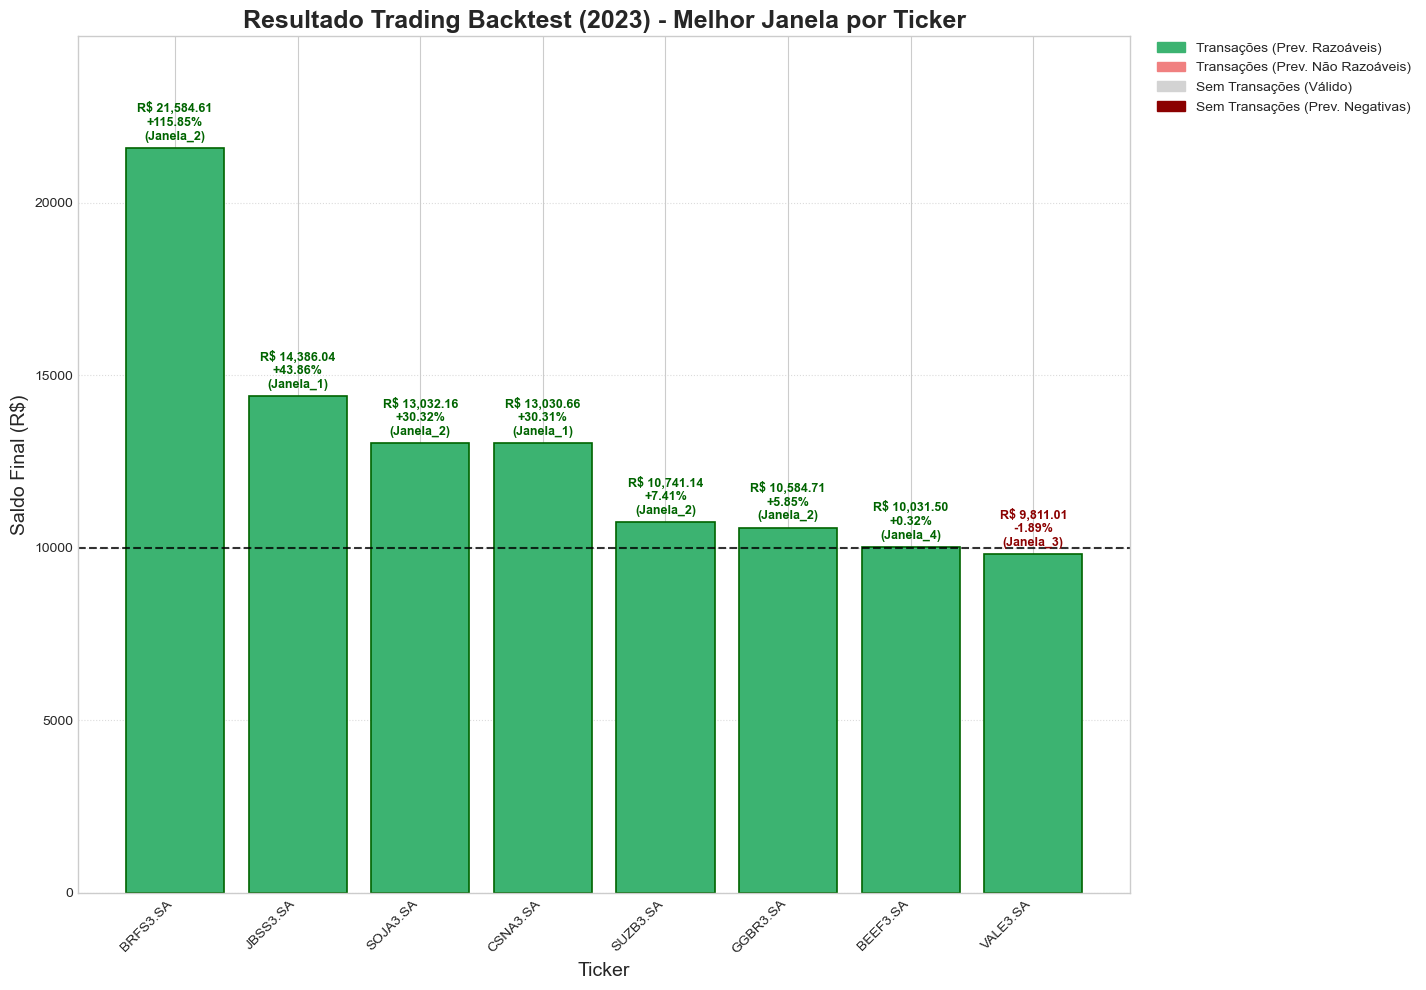


--- Execução Concluída ---


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Importar mpatches

# Diretório onde estão os arquivos de previsões
input_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\Macro"

# Diretório onde os resultados serão salvos
output_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroResultados"
os.makedirs(output_dir, exist_ok=True)

# Diretório para salvar as transações
transactions_dir = os.path.join(output_dir, "Transacoes")
os.makedirs(transactions_dir, exist_ok=True)

# Lista de tickers
tickers = ["BEEF3.SA", "BRFS3.SA", "VALE3.SA", "JBSS3.SA", "SOJA3.SA", "SUZB3.SA", "GGBR3.SA", "CSNA3.SA"]

# Lista de janelas
janelas = ["Janela_1", "Janela_2", "Janela_3", "Janela_4"]

# Estratégia "All-In" usando apenas previsões originais
def estrategia_all_in(dados_brutos, saldo_inicial):
    # Converter colunas para valores numéricos sem substituir as previsões
    dados = dados_brutos.copy()
    dados['Preço Real'] = pd.to_numeric(dados['Preço Real'], errors='coerce')
    dados['Preço Previsto'] = pd.to_numeric(dados['Preço Previsto'], errors='coerce')

    # Verificar se as previsões estão dentro de um intervalo razoável, apenas para diagnóstico
    previsoes = dados['Preço Previsto'].dropna()
    min_previsto = previsoes.min() if len(previsoes) > 0 else None
    max_previsto = previsoes.max() if len(previsoes) > 0 else None
    media_previsoes = previsoes.mean() if len(previsoes) > 0 else None

    # Imprimir informações sobre as previsões (PARA DEBUG)
    identifier = dados_brutos['Data'].iloc[0] if not dados_brutos.empty and 'Data' in dados_brutos.columns else "Unknown"
    # print(f"\n--- Debug Info for {identifier} ---") # Comentado para reduzir output
    # print(f"Min Previsto: {min_previsto}, Max Previsto: {max_previsto}, Média Previsto: {media_previsoes}")
    # print(f"Tipo Min Previsto: {type(min_previsto)}")

    # VERIFICAR SE A PREVISÃO MÍNIMA É EXTREMAMENTE NEGATIVA
    is_extremely_negative = False
    if min_previsto is not None and isinstance(min_previsto, (int, float)) and min_previsto < -1000:
        is_extremely_negative = True
        print(f"!!! DEBUG: Previsão mínima ({min_previsto}) é < -1000 para {identifier}. Marcado para bloquear transações. !!!")

    # Se marcado como extremamente negativo, retornar imediatamente
    if is_extremely_negative:
        # print(f"Previsões negativas extremas detectadas (Min={min_previsto}). Não realizando transações.") # Comentado
        diagnostico = {
            'Previsões Razoáveis': False,
            'Estratégia Usada': 'Sem transações - Previsões Negativas',
            'Total de Transações': 0,
            'Retorno (%)': 0.0,
            'Min Previsto': min_previsto,
            'Max Previsto': max_previsto,
            'Média Previsto': media_previsoes
        }
        return saldo_inicial, [], diagnostico # Retorna lista VAZIA de transações
    # else: # Comentado para reduzir output
         # print(f"Debug: Previsão mínima ({min_previsto}) não é < -1000 ou é None/Inválida. Prosseguindo com a estratégia...")

    # Prosseguir com a estratégia (somente se não for extremamente negativo)
    saldo = saldo_inicial
    quantidade_acoes = 0
    transacoes = [] # Começa vazia

    for i in range(len(dados) - 1):
        data_atual = dados.iloc[i]['Data']
        preco_real = dados.iloc[i]['Preço Real']
        if pd.isna(preco_real) or preco_real <= 0: continue
        preco_previsto = dados.iloc[i + 1]['Preço Previsto']
        if pd.isna(preco_previsto): continue

        if quantidade_acoes == 0 and preco_previsto > preco_real:
            quantidade_acoes = saldo / preco_real
            valor_transacao = saldo
            saldo = 0
            transacoes.append({'Data': data_atual, 'Acao': 'Compra', 'Preco': preco_real, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        elif quantidade_acoes > 0 and preco_previsto < preco_real and i < len(dados) - 2: # Evita vender no penúltimo dia baseado na última previsão
            valor_transacao = quantidade_acoes * preco_real
            saldo = valor_transacao
            transacoes.append({'Data': data_atual, 'Acao': 'Venda', 'Preco': preco_real, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
            quantidade_acoes = 0

    # Venda final no último dia se ainda houver ações
    if quantidade_acoes > 0:
        ultimo_preco = dados.iloc[-1]['Preço Real']
        if not pd.isna(ultimo_preco) and ultimo_preco > 0:
            valor_transacao = quantidade_acoes * ultimo_preco
            saldo = valor_transacao
            transacoes.append({'Data': dados.iloc[-1]['Data'], 'Acao': 'Venda Final', 'Preco': ultimo_preco, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        else:
             # Se o último preço for inválido, considera perda total do valor investido
             print(f"AVISO: Último preço real inválido para {identifier}. Saldo zerado na venda final.")
             saldo = 0 # Ou outra lógica de tratamento, como usar o penúltimo preço

    # Diagnóstico Final
    previsoes_razoaveis = not is_extremely_negative # Simplificado: Razoável se não for extremamente negativo
    estrategia_usada_diag = 'Previsões Originais' if len(transacoes) > 0 else 'Sem transações'
    if is_extremely_negative: # Garante que a flag negativa sobrescreva
        estrategia_usada_diag = 'Sem transações - Previsões Negativas'

    diagnostico = {
        'Previsões Razoáveis': previsoes_razoaveis,
        'Estratégia Usada': estrategia_usada_diag,
        'Total de Transações': len(transacoes),
        'Retorno (%)': ((saldo - saldo_inicial) / saldo_inicial) * 100 if saldo_inicial != 0 else 0,
        'Min Previsto': min_previsto,
        'Max Previsto': max_previsto,
        'Média Previsto': media_previsoes
    }
    # print(f"Diagnóstico da estratégia para {identifier}: {diagnostico}") # Comentado

    return saldo, transacoes, diagnostico

# Processar os resultados de previsões para todos os tickers, comparando as janelas
def processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial):
    resultados = []
    todas_transacoes = {}
    todos_diagnosticos = {}

    for ticker in tickers:
        ticker_resultados = {'Ticker': ticker}
        todas_transacoes[ticker] = {}
        todos_diagnosticos[ticker] = {}
        print(f"\nProcessando {ticker}...")
        for janela in janelas:
            previsoes_file = os.path.join(input_dir, ticker, janela, f"{ticker}_{janela}_previsoes_teste_final.csv")
            if os.path.exists(previsoes_file):
                try:
                    dados = pd.read_csv(previsoes_file)
                    # Adiciona identificador único para a função de estratégia
                    dados['Data'] = dados['Data'] + f"_{ticker}_{janela}" 
                    saldo_final, transacoes, diagnostico = estrategia_all_in(dados, saldo_inicial)
                    todas_transacoes[ticker][janela] = transacoes
                    todos_diagnosticos[ticker][janela] = diagnostico
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_final
                    ticker_resultados[f"Retorno {janela} (%)"] = diagnostico['Retorno (%)']
                    ticker_resultados[f"Estratégia {janela}"] = diagnostico['Estratégia Usada']
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = diagnostico['Previsões Razoáveis']
                    print(f"  {janela}: Saldo={saldo_final:.2f}, Estratégia='{diagnostico['Estratégia Usada']}'")
                except Exception as e:
                    print(f"  Erro ao processar {ticker} - {janela}: {str(e)}")
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                    ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                    ticker_resultados[f"Estratégia {janela}"] = "Erro"
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = False
            else:
                print(f"  Arquivo não encontrado: {previsoes_file}")
                ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                ticker_resultados[f"Estratégia {janela}"] = "Arquivo não encontrado"
                ticker_resultados[f"Previsões Razoáveis {janela}"] = False
        resultados.append(ticker_resultados)
    return pd.DataFrame(resultados), todas_transacoes, todos_diagnosticos

# --- CÓDIGO PRINCIPAL ---
saldo_inicial = 10000
df_resultados, todas_transacoes, todos_diagnosticos = processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial)

# Salvar resultados comparativos
resultados_filepath = os.path.join(output_dir, "resultados_comparativos_janelas.csv")
df_resultados.to_csv(resultados_filepath, index=False)
print(f"\nResultados comparativos salvos em: {resultados_filepath}")

# Salvar diagnósticos
diagnosticos_list = []
for ticker in todos_diagnosticos:
    for janela in todos_diagnosticos.get(ticker, {}):
        if todos_diagnosticos[ticker][janela]:
            diagnostico = todos_diagnosticos[ticker][janela].copy()
            diagnostico['Ticker'] = ticker; diagnostico['Janela'] = janela
            diagnosticos_list.append(diagnostico)
if diagnosticos_list:
    df_diagnosticos = pd.DataFrame(diagnosticos_list)
    diagnosticos_filepath = os.path.join(output_dir, "diagnosticos_estrategias.csv")
    df_diagnosticos.to_csv(diagnosticos_filepath, index=False)
    print(f"Diagnósticos de estratégias salvos em: {diagnosticos_filepath}")

# Salvar TODAS as transações
print("\n--- Iniciando salvamento de TODAS as transações por janela ---")
for ticker in tickers:
    ticker_dir = os.path.join(transactions_dir, ticker)
    os.makedirs(ticker_dir, exist_ok=True)
    for janela in janelas:
        if janela in todas_transacoes.get(ticker, {}):
            transacoes = todas_transacoes[ticker][janela]
            if transacoes: # Salva SOMENTE se a lista NÃO for vazia
                df_transacoes = pd.DataFrame(transacoes)
                transacoes_filepath = os.path.join(ticker_dir, f"{ticker}_{janela}_transacoes.csv")
                df_transacoes.to_csv(transacoes_filepath, index=False)
                # print(f"    SALVANDO Transações para {ticker} - {janela}") # Comentado
            # else: # Comentado
                # print(f"    NÃO SALVANDO Transações para {ticker}, Janela {janela} (lista vazia)")
        # else: # Comentado
             # print(f"    AVISO: Não foram encontradas transações no dicionário para {ticker}, Janela {janela}")
print("--- Salvamento de TODAS as transações concluído ---")


# Identificar a MELHOR JANELA para cada ticker (LÓGICA AJUSTADA)
print("\n--- Identificando melhor janela para cada ticker (Lógica Ajustada) ---")
melhores_resultados_plot = []
for _, row in df_resultados.iterrows():
    ticker = row['Ticker']
    
    melhor_janela_final = None
    melhor_saldo_final = -np.inf
    melhor_estrategia_final = None
    tem_transacoes_final = False
    print_msg = "Nenhuma janela válida encontrada" # Default message

    # 1. Buscar a melhor janela COM transações ('Previsões Originais')
    melhor_janela_com_trans = None
    melhor_saldo_com_trans = -np.inf
    for janela in janelas:
        estrategia = row.get(f"Estratégia {janela}")
        saldo = row.get(f"Saldo Final {janela}")
        if estrategia == 'Previsões Originais' and saldo is not None and pd.notna(saldo):
            if saldo > melhor_saldo_com_trans:
                melhor_saldo_com_trans = saldo
                melhor_janela_com_trans = janela

    # 2. Se encontrou janela COM transações, usar essa
    if melhor_janela_com_trans is not None:
        melhor_janela_final = melhor_janela_com_trans
        melhor_saldo_final = melhor_saldo_com_trans
        melhor_estrategia_final = 'Previsões Originais'
        tem_transacoes_final = True
        print_msg = "Melhor janela válida com transações"
    else:
        # 3. Se NÃO encontrou com transações, buscar a melhor janela SEM transações (mas válida)
        melhor_janela_sem_trans = None
        # Para 'Sem transações', o saldo é sempre o inicial, então apenas pegamos a primeira válida encontrada
        for janela in janelas:
            estrategia = row.get(f"Estratégia {janela}")
            # Aceita 'Sem transações', exclui as inválidas
            if estrategia == 'Sem transações': 
                 if melhor_janela_sem_trans is None: # Pega a primeira janela 'Sem transações'
                     melhor_janela_sem_trans = janela
                     break # Já achamos uma, não precisamos de outras 'Sem transações'
        
        # 4. Se encontrou janela 'Sem transações', usar essa
        if melhor_janela_sem_trans is not None:
             melhor_janela_final = melhor_janela_sem_trans
             melhor_saldo_final = saldo_inicial # Saldo é o inicial
             melhor_estrategia_final = 'Sem transações'
             tem_transacoes_final = False
             print_msg = "Janela selecionada (sem transações)"
        else:
             # 5. Fallback: Se só sobraram erros, previsões negativas ou não encontrados
             # Tenta pegar a primeira janela que não seja explicitamente negativa ou erro
             for janela in janelas:
                 estrategia = row.get(f"Estratégia {janela}")
                 if estrategia not in ['Sem transações - Previsões Negativas', 'Erro', 'Arquivo não encontrado']:
                     melhor_janela_final = janela
                     melhor_saldo_final = saldo_inicial
                     melhor_estrategia_final = estrategia # Pode ser None se a coluna não existir
                     tem_transacoes_final = False
                     print_msg = "Janela selecionada (fallback, sem transações)"
                     break
             # 6. Fallback extremo: Se TUDO falhou (improvável)
             if melhor_janela_final is None:
                 melhor_janela_final = janelas[0]
                 melhor_saldo_final = saldo_inicial
                 melhor_estrategia_final = row.get(f"Estratégia {janelas[0]}", "Status Desconhecido")
                 tem_transacoes_final = False
                 print_msg = "Janela selecionada (fallback extremo)"

    # Adicionar aos resultados para plotagem
    previsoes_razoaveis = row.get(f"Previsões Razoáveis {melhor_janela_final}", False)
    # Garante que se a estratégia for negativa, as previsões sejam marcadas como não razoáveis
    if melhor_estrategia_final == 'Sem transações - Previsões Negativas':
        previsoes_razoaveis = False
        
    melhores_resultados_plot.append({
        'Ticker': ticker, 
        'Melhor Janela': melhor_janela_final, 
        'Saldo Final': melhor_saldo_final,
        # Pega o retorno da janela selecionada, ou 0.0 se não houver
        'Retorno (%)': row.get(f"Retorno {melhor_janela_final} (%)", 0.0), 
        'Estratégia Usada': melhor_estrategia_final if melhor_estrategia_final is not None else "N/A",
        'Previsões Razoáveis': previsoes_razoaveis,
        'Tem Transações': tem_transacoes_final # Usa a flag definida na lógica acima
    })
    print(f"    {print_msg} para {ticker}: {melhor_janela_final} (Saldo: {melhor_saldo_final:.2f}, Estratégia: {melhor_estrategia_final})")

# Processar e salvar MELHORES resultados
df_melhores_plot = pd.DataFrame(melhores_resultados_plot).sort_values(by='Retorno (%)', ascending=False)

melhores_filepath = os.path.join(output_dir, "melhores_resultados.csv")
df_melhores_plot.to_csv(melhores_filepath, index=False)
print(f"\nMelhores resultados (lógica ajustada) salvos em: {melhores_filepath}")

# Salvar transações SOMENTE da MELHOR JANELA (se teve transações)
print("\n--- Iniciando salvamento das transações da MELHOR janela (se houver) ---")
todas_melhores_transacoes_list = [] 
for idx, row in df_melhores_plot.iterrows():
    ticker = row['Ticker']
    melhor_janela = row['Melhor Janela']
    
    # Salva apenas se 'Tem Transações' for True (ou seja, estratégia foi 'Previsões Originais')
    if not row['Tem Transações']: 
        # print(f"    Sem transações para {ticker} na janela {melhor_janela}, não salvando arquivo.") # Comentado
        continue

    if ticker in todas_transacoes and melhor_janela in todas_transacoes.get(ticker, {}):
        transacoes_melhor = todas_transacoes[ticker][melhor_janela]
        if transacoes_melhor: 
            # print(f"    SALVANDO Melhor Transação para {ticker}, Janela {melhor_janela}") # Comentado
            df_transacoes_melhor = pd.DataFrame(transacoes_melhor)
            melhor_transacoes_filepath = os.path.join(transactions_dir, f"{ticker}_MELHOR_JANELA_{melhor_janela}_transacoes.csv")
            df_transacoes_melhor.to_csv(melhor_transacoes_filepath, index=False)
            # print(f"        Salvo em: {melhor_transacoes_filepath}") # Comentado

            # Adicionar ao consolidado
            for transacao in transacoes_melhor:
                transacao_info = {'Ticker': ticker, 'Janela': melhor_janela, 'Estratégia': row['Estratégia Usada'], 'Previsões Razoáveis': row['Previsões Razoáveis'], **transacao}
                todas_melhores_transacoes_list.append(transacao_info)
        # else: # Comentado
             # print(f"    NÃO SALVANDO Melhor Transação para {ticker}, Janela {melhor_janela} (lista vazia)")
    # else: # Comentado
        # print(f"    AVISO: Não foram encontradas transações no dicionário para a melhor janela de {ticker} ({melhor_janela})")
print("--- Salvamento das MELHORES transações concluído ---")

# Salvar consolidado se houver dados
if todas_melhores_transacoes_list:
    df_todas_melhores = pd.DataFrame(todas_melhores_transacoes_list)
    consolidado_filepath = os.path.join(output_dir, "todas_melhores_transacoes_consolidado.csv")
    df_todas_melhores.to_csv(consolidado_filepath, index=False)
    print(f"\nTodas as transações das melhores janelas consolidadas em: {consolidado_filepath}")

# Gerar gráfico final (incluindo todos os tickers)
print("\n--- Gerando gráfico final (Lógica Ajustada) ---")
plt.style.use('seaborn-v0_8-whitegrid') # Usar um estilo diferente
plt.figure(figsize=(16, 10)) # Aumentar tamanho

# Cores baseadas na lógica ajustada
colors = []
edge_colors = []
for idx, row in df_melhores_plot.iterrows():
    if row['Estratégia Usada'] == 'Sem transações - Previsões Negativas':
         colors.append('darkred') # Vermelho escuro para previsões negativas
         edge_colors.append('black')
    elif not row['Tem Transações']:
        colors.append('lightgray')  # Cinza para tickers sem transações (mas válidos)
        edge_colors.append('dimgray')
    elif row['Previsões Razoáveis']:
        colors.append('mediumseagreen') # Verde para previsões razoáveis com transações
        edge_colors.append('darkgreen')
    else: # Transações com previsões não razoáveis (mas não negativas extremas)
        colors.append('lightcoral') # Coral claro
        edge_colors.append('darkred')


bars = plt.bar(df_melhores_plot['Ticker'], df_melhores_plot['Saldo Final'], 
               color=colors, edgecolor=edge_colors, linewidth=1.2) # Adiciona borda
plt.axhline(y=saldo_inicial, color='black', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')

# Adicionar rótulos com informações
for i, bar in enumerate(bars):
    row = df_melhores_plot.iloc[i]
    saldo = row['Saldo Final']
    retorno = row['Retorno (%)']
    janela = row['Melhor Janela']
    estrategia = row['Estratégia Usada']
    
    y_pos = bar.get_height() + 150 # Posição base do texto
    
    if estrategia == 'Sem transações - Previsões Negativas':
         plt.text(i, y_pos, "Previsões\nNegativas", ha='center', va='bottom', color='darkred', fontsize=9, fontweight='bold')
    elif not row['Tem Transações']:
        plt.text(i, y_pos, f"Sem\nTransações\n({janela})", ha='center', va='bottom', color='dimgray', fontsize=9)
    else: # Teve transações
        text_color = 'darkgreen' if retorno >= 0 else 'darkred'
        retorno_text = f"+{retorno:.2f}%" if retorno >= 0 else f"{retorno:.2f}%"
        plt.text(i, y_pos,
                 f"R$ {saldo:,.2f}\n{retorno_text}\n({janela})",
                 ha='center', va='bottom', fontweight='bold', color=text_color, fontsize=9)

plt.title('Resultado Trading Backtest (2023) - Melhor Janela por Ticker', fontsize=18, fontweight='bold')
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Saldo Final (R$)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.ylim(bottom=0, top=df_melhores_plot['Saldo Final'].max() * 1.15) # Ajusta limite superior

# Legenda Atualizada
trans_razoaveis_patch = mpatches.Patch(color='mediumseagreen', label='Transações (Prev. Razoáveis)')
trans_nao_razoaveis_patch = mpatches.Patch(color='lightcoral', label='Transações (Prev. Não Razoáveis)')
sem_trans_patch = mpatches.Patch(color='lightgray', label='Sem Transações (Válido)')
prev_neg_patch = mpatches.Patch(color='darkred', label='Sem Transações (Prev. Negativas)')
# saldo_inicial_line = mpatches.Patch(color='black', linestyle='--', label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}') # Linha já tem label

plt.legend(handles=[trans_razoaveis_patch, trans_nao_razoaveis_patch, sem_trans_patch, prev_neg_patch, bars[0]], # Adiciona a linha do saldo inicial à legenda
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10) 
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Ajusta layout para caber a legenda

grafico_final_filepath = os.path.join(output_dir, "resultado_trading_grafico_ajustado.png")
plt.savefig(grafico_final_filepath, dpi=300, bbox_inches='tight')
print(f"Gráfico final (ajustado) salvo em: {grafico_final_filepath}")
plt.show()

print("\n--- Execução Concluída ---")


Processando BEEF3.SA (Estratégia Direção Previsão)...
  Janela_1: Saldo=10099.69, Estratégia='Direção Previsão'
  Janela_2: Saldo=9105.93, Estratégia='Direção Previsão'
  Janela_3: Saldo=7203.42, Estratégia='Direção Previsão'
  Janela_4: Saldo=7354.33, Estratégia='Direção Previsão'

Processando BRFS3.SA (Estratégia Direção Previsão)...
  Janela_1: Saldo=15786.18, Estratégia='Direção Previsão'
  Janela_2: Saldo=12633.39, Estratégia='Direção Previsão'
  Janela_3: Saldo=11743.09, Estratégia='Direção Previsão'
  Janela_4: Saldo=7354.33, Estratégia='Direção Previsão'

Processando BRFS3.SA (Estratégia Direção Previsão)...
  Janela_1: Saldo=15786.18, Estratégia='Direção Previsão'
  Janela_2: Saldo=12633.39, Estratégia='Direção Previsão'
  Janela_3: Saldo=11743.09, Estratégia='Direção Previsão'
  Janela_4: Saldo=12364.96, Estratégia='Direção Previsão'

Processando VALE3.SA (Estratégia Direção Previsão)...
  Janela_1: Saldo=10314.02, Estratégia='Direção Previsão'
  Janela_2: Saldo=9390.02, Est

C:\Users\leona\AppData\Local\Temp\ipykernel_14324\4203887414.py:426: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=[trans_razoaveis_patch, sem_trans_patch, prev_prob_patch, outros_prob_patch, bars[0]], # Adicionar patch de outros problemas


Gráfico final (Estratégia Direção) salvo em: c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicroResultados\resultado_trading_grafico_direcao.png


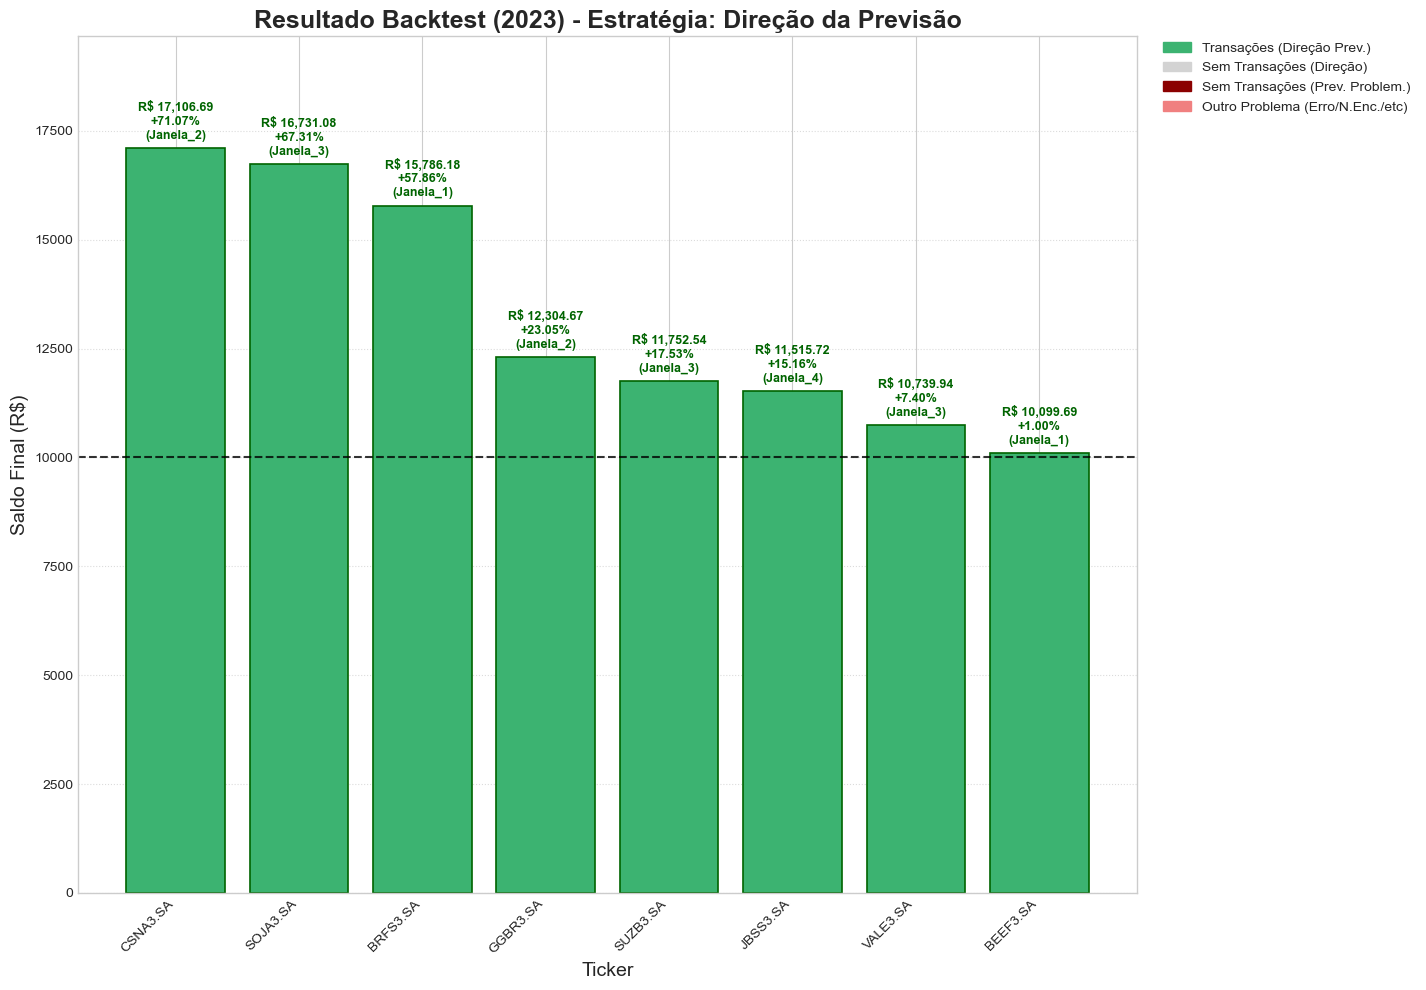


--- Execução Concluída (Estratégia Direção Previsão) ---


In [45]:
# Cell 2: Estratégia Direção Previsão (Completo e Corrigido)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Importar mpatches

# Diretório onde estão os arquivos de previsões
input_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicro"

# Diretório onde os resultados serão salvos
output_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicroResultados"
os.makedirs(output_dir, exist_ok=True)

# Diretório para salvar as transações
transactions_dir = os.path.join(output_dir, "Transacoes_Estrategia_Direcao") # Subpasta para esta estratégia
os.makedirs(transactions_dir, exist_ok=True)

# Lista de tickers
tickers = ["BEEF3.SA", "BRFS3.SA", "VALE3.SA", "JBSS3.SA", "SOJA3.SA", "SUZB3.SA", "GGBR3.SA", "CSNA3.SA"]

# Lista de janelas
janelas = ["Janela_1", "Janela_2", "Janela_3", "Janela_4"]

# --- ESTRATÉGIA 2: Usar a DIREÇÃO DA PREVISÃO ---
def estrategia_direcao_previsao(dados_brutos, saldo_inicial):
    # Converter colunas para valores numéricos
    dados = dados_brutos.copy()
    dados['Preço Real'] = pd.to_numeric(dados['Preço Real'], errors='coerce')
    dados['Preço Previsto'] = pd.to_numeric(dados['Preço Previsto'], errors='coerce')

    # --- Verificação de Previsões Problemáticas (AMPLIADA) ---
    previsoes = dados['Preço Previsto'].dropna()
    min_previsto = previsoes.min() if len(previsoes) > 0 else None
    max_previsto = previsoes.max() if len(previsoes) > 0 else None
    media_previsoes = previsoes.mean() if len(previsoes) > 0 else None
    # Usar a coluna 'Data' que foi passada (originalmente 'Data_ID')
    identifier = dados_brutos['Data'].iloc[0] if not dados_brutos.empty and 'Data' in dados_brutos.columns else "Unknown"

    # Definir um limite superior razoável (ex: 10x o preço real máximo ou um valor fixo alto)
    max_real_price = dados['Preço Real'].dropna().max()
    # Usar um limite superior fixo alto como fallback se não houver preços reais válidos
    upper_limit = max(max_real_price * 10, 10000) if pd.notna(max_real_price) and max_real_price > 0 else 10000

    is_problematic = False
    reason = ""
    if any(p < 0 for p in previsoes if pd.notna(p)):
        is_problematic = True
        reason = f"Previsão negativa detectada (Min={min_previsto})"
    elif min_previsto is not None and isinstance(min_previsto, (int, float)) and min_previsto < -1000:
        is_problematic = True
        reason = f"Previsão mínima extrema detectada (Min={min_previsto})"
    elif max_previsto is not None and isinstance(max_previsto, (int, float)) and max_previsto > upper_limit: # NOVA VERIFICAÇÃO DE LIMITE SUPERIOR
        is_problematic = True
        reason = f"Previsão máxima extrema detectada (Max={max_previsto} > Limite={upper_limit})"
    # Adicionar outras verificações aqui se necessário (ex: desvio padrão muito alto, etc.)

    if is_problematic:
        print(f"!!! DEBUG: Previsão problemática detectada para {identifier}. {reason}. Bloqueando transações (Direção). !!!")
        diagnostico = {
            'Previsões Razoáveis': False,
            # Usar um nome consistente para todos os bloqueios por previsão
            'Estratégia Usada': 'Sem transações - Previsões Problemáticas',
            'Total de Transações': 0, 'Retorno (%)': 0.0,
            'Min Previsto': min_previsto, 'Max Previsto': max_previsto, 'Média Previsto': media_previsoes
        }
        return saldo_inicial, [], diagnostico
    # --- Fim da Verificação ---

    saldo = saldo_inicial
    quantidade_acoes = 0
    transacoes = []

    for i in range(len(dados) - 1):
        data_atual = dados.iloc[i]['Data'] # Usar a coluna 'Data' (que veio de 'Data_ID')
        preco_real_atual = dados.iloc[i]['Preço Real'] # Usado apenas para registrar o preço da transação
        if pd.isna(preco_real_atual) or preco_real_atual <= 0: continue

        preco_previsto_atual = dados.iloc[i]['Preço Previsto']
        preco_previsto_seguinte = dados.iloc[i + 1]['Preço Previsto']

        # Ignora se alguma das previsões for NaN
        if pd.isna(preco_previsto_atual) or pd.isna(preco_previsto_seguinte): continue

        # --- LÓGICA DE DECISÃO MODIFICADA (Direção da Previsão) ---
        previsao_indica_subida = preco_previsto_seguinte > preco_previsto_atual
        previsao_indica_descida = preco_previsto_seguinte < preco_previsto_atual
        # --- Fim da Modificação ---

        if quantidade_acoes == 0 and previsao_indica_subida: # Comprar se prevê subida na PREVISÃO
            quantidade_acoes = saldo / preco_real_atual # Compra ao preço real atual
            valor_transacao = saldo
            saldo = 0
            transacoes.append({'Data': data_atual, 'Acao': 'Compra', 'Preco': preco_real_atual, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        elif quantidade_acoes > 0 and previsao_indica_descida and i < len(dados) - 2: # Vender se prevê descida na PREVISÃO
            valor_transacao = quantidade_acoes * preco_real_atual # Vende ao preço real atual
            saldo = valor_transacao
            transacoes.append({'Data': data_atual, 'Acao': 'Venda', 'Preco': preco_real_atual, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
            quantidade_acoes = 0

    # Venda final no último dia
    if quantidade_acoes > 0:
        ultimo_preco = dados.iloc[-1]['Preço Real']
        if not pd.isna(ultimo_preco) and ultimo_preco > 0:
            valor_transacao = quantidade_acoes * ultimo_preco
            saldo = valor_transacao
            transacoes.append({'Data': dados.iloc[-1]['Data'], 'Acao': 'Venda Final', 'Preco': ultimo_preco, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        else:
             print(f"AVISO: Último preço real inválido para {identifier}. Saldo zerado na venda final.")
             saldo = 0

    # Diagnóstico Final
    previsoes_razoaveis = not is_problematic # Usar a nova flag
    estrategia_usada_diag = 'Direção Previsão' if len(transacoes) > 0 else 'Sem transações (Direção)'
    # Sobrescrever se foi problemático (já tratado no início, mas para garantir)
    if is_problematic:
        estrategia_usada_diag = 'Sem transações - Previsões Problemáticas'

    diagnostico = {
        'Previsões Razoáveis': previsoes_razoaveis,
        'Estratégia Usada': estrategia_usada_diag,
        'Total de Transações': len(transacoes),
        'Retorno (%)': ((saldo - saldo_inicial) / saldo_inicial) * 100 if saldo_inicial != 0 else 0,
        'Min Previsto': min_previsto, 'Max Previsto': max_previsto, 'Média Previsto': media_previsoes
    }

    return saldo, transacoes, diagnostico

# Processar os resultados de previsões para todos os tickers, comparando as janelas
def processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial):
    resultados = []
    todas_transacoes = {}
    todos_diagnosticos = {}

    for ticker in tickers:
        ticker_resultados = {'Ticker': ticker}
        todas_transacoes[ticker] = {}
        todos_diagnosticos[ticker] = {}
        print(f"\nProcessando {ticker} (Estratégia Direção Previsão)...") # Indicar estratégia
        for janela in janelas:
            previsoes_file = os.path.join(input_dir, ticker, janela, f"{ticker}_{janela}_previsoes_teste_final.csv")
            if os.path.exists(previsoes_file):
                try:
                    dados = pd.read_csv(previsoes_file)
                    # Limpar e adicionar identificador único para a função de estratégia
                    dados['Data'] = dados['Data'].astype(str).str.replace(r'_[A-Z0-9]+\.SA_Janela_[1-4]$', '', regex=True)
                    dados['Data_ID'] = dados['Data'] + f"_{ticker}_{janela}" # Usar coluna separada para ID

                    # --- CHAMANDO A NOVA ESTRATÉGIA ---
                    # Passar dados com Data_ID renomeado para 'Data'
                    saldo_final, transacoes, diagnostico = estrategia_direcao_previsao(dados.rename(columns={'Data_ID': 'Data'}), saldo_inicial)
                    # --- Fim da Modificação ---
                    todas_transacoes[ticker][janela] = transacoes
                    todos_diagnosticos[ticker][janela] = diagnostico
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_final
                    ticker_resultados[f"Retorno {janela} (%)"] = diagnostico['Retorno (%)']
                    ticker_resultados[f"Estratégia {janela}"] = diagnostico['Estratégia Usada']
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = diagnostico['Previsões Razoáveis']
                    print(f"  {janela}: Saldo={saldo_final:.2f}, Estratégia='{diagnostico['Estratégia Usada']}'")
                except Exception as e:
                    print(f"  Erro ao processar {ticker} - {janela}: {str(e)}")
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                    ticker_resultados[f"Retorno {janela} (%)"] = 0.0 # Corrigido
                    ticker_resultados[f"Estratégia {janela}"] = "Erro"
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = False
            else:
                print(f"  Arquivo não encontrado: {previsoes_file}")
                ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                ticker_resultados[f"Estratégia {janela}"] = "Arquivo não encontrado"
                ticker_resultados[f"Previsões Razoáveis {janela}"] = False
        resultados.append(ticker_resultados)
    return pd.DataFrame(resultados), todas_transacoes, todos_diagnosticos

# --- CÓDIGO PRINCIPAL ---
saldo_inicial = 10000
df_resultados, todas_transacoes, todos_diagnosticos = processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial)

# Salvar resultados comparativos
resultados_filepath = os.path.join(output_dir, "resultados_comparativos_janelas_direcao.csv") # Nome do arquivo ajustado
df_resultados.to_csv(resultados_filepath, index=False)
print(f"\nResultados comparativos (Estratégia Direção) salvos em: {resultados_filepath}")

# Salvar diagnósticos
diagnosticos_list = []
for ticker in todos_diagnosticos:
    for janela in todos_diagnosticos.get(ticker, {}):
        if todos_diagnosticos[ticker][janela]:
            diagnostico = todos_diagnosticos[ticker][janela].copy()
            diagnostico['Ticker'] = ticker; diagnostico['Janela'] = janela
            diagnosticos_list.append(diagnostico)
if diagnosticos_list:
    df_diagnosticos = pd.DataFrame(diagnosticos_list)
    diagnosticos_filepath = os.path.join(output_dir, "diagnosticos_estrategia_direcao.csv") # Nome do arquivo ajustado
    df_diagnosticos.to_csv(diagnosticos_filepath, index=False)
    print(f"Diagnósticos de estratégias (Direção) salvos em: {diagnosticos_filepath}")

# Salvar TODAS as transações
print("\n--- Iniciando salvamento de TODAS as transações por janela (Estratégia Direção) ---")
for ticker in tickers:
    ticker_dir = os.path.join(transactions_dir, ticker) # Usa a subpasta definida
    os.makedirs(ticker_dir, exist_ok=True)
    for janela in janelas:
        if janela in todas_transacoes.get(ticker, {}):
            transacoes = todas_transacoes[ticker][janela]
            if transacoes:
                df_transacoes = pd.DataFrame(transacoes)
                transacoes_filepath = os.path.join(ticker_dir, f"{ticker}_{janela}_transacoes_direcao.csv") # Nome do arquivo ajustado
                df_transacoes.to_csv(transacoes_filepath, index=False)
print("--- Salvamento de TODAS as transações (Direção) concluído ---")


# Identificar a MELHOR JANELA para cada ticker (LÓGICA AJUSTADA para Estratégia Direção)
print("\n--- Identificando melhor janela para cada ticker (Estratégia Direção) ---")
melhores_resultados_plot = []
for _, row in df_resultados.iterrows():
    ticker = row['Ticker']

    melhor_janela_final = None
    melhor_saldo_final = -np.inf
    melhor_estrategia_final = None
    tem_transacoes_final = False
    print_msg = "Nenhuma janela válida encontrada"

    # 1. Buscar a melhor janela COM transações ('Direção Previsão')
    melhor_janela_com_trans = None
    melhor_saldo_com_trans = -np.inf
    for janela in janelas:
        estrategia = row.get(f"Estratégia {janela}")
        saldo = row.get(f"Saldo Final {janela}")
        if estrategia == 'Direção Previsão' and saldo is not None and pd.notna(saldo):
            if saldo > melhor_saldo_com_trans:
                melhor_saldo_com_trans = saldo
                melhor_janela_com_trans = janela

    # 2. Se encontrou janela COM transações, usar essa
    if melhor_janela_com_trans is not None:
        melhor_janela_final = melhor_janela_com_trans
        melhor_saldo_final = melhor_saldo_com_trans
        melhor_estrategia_final = 'Direção Previsão'
        tem_transacoes_final = True
        print_msg = "Melhor janela válida com transações (Direção)"
    else:
        # 3. Se NÃO encontrou com transações, buscar a melhor janela SEM transações NORMAL ('Sem transações (Direção)')
        melhor_janela_sem_trans_normal = None
        for janela in janelas:
            estrategia = row.get(f"Estratégia {janela}")
            if estrategia == 'Sem transações (Direção)':
                 if melhor_janela_sem_trans_normal is None:
                     melhor_janela_sem_trans_normal = janela
                     break

        # 4. Se encontrou janela 'Sem transações (Direção)', usar essa
        if melhor_janela_sem_trans_normal is not None:
             melhor_janela_final = melhor_janela_sem_trans_normal
             melhor_saldo_final = saldo_inicial
             melhor_estrategia_final = 'Sem transações (Direção)'
             tem_transacoes_final = False
             print_msg = "Janela selecionada (sem transações - Direção)"
        else:
             # 5. Se não achou nem com transação, nem sem transação normal, procurar por 'Sem transações - Previsões Problemáticas'
             melhor_janela_problematica = None
             for janela in janelas:
                 estrategia = row.get(f"Estratégia {janela}")
                 # --- AJUSTE AQUI ---
                 if estrategia == 'Sem transações - Previsões Problemáticas': # Usar o nome novo/consistente
                     if melhor_janela_problematica is None:
                         melhor_janela_problematica = janela
                         break # Pega a primeira problemática

             if melhor_janela_problematica is not None: # Se achou uma problemática
                 melhor_janela_final = melhor_janela_problematica
                 melhor_saldo_final = saldo_inicial
                 melhor_estrategia_final = 'Sem transações - Previsões Problemáticas' # Usar o nome novo
                 tem_transacoes_final = False
                 print_msg = "Janela selecionada (previsões problemáticas)"
             else:
                 # 6. Fallback extremo: Se sobrou apenas 'Erro' ou 'Arquivo não encontrado'
                 melhor_janela_final = janelas[0] # Pega a primeira janela de qualquer jeito
                 melhor_saldo_final = saldo_inicial
                 melhor_estrategia_final = row.get(f"Estratégia {janelas[0]}", "Status Desconhecido") # Pega o status dela
                 tem_transacoes_final = False
                 print_msg = "Janela selecionada (fallback extremo - Direção)"
                 # Garantir que o status aqui não seja confundido com transações válidas
                 if melhor_estrategia_final not in ['Sem transações (Direção)', 'Sem transações - Previsões Problemáticas', 'Erro', 'Arquivo não encontrado']:
                     melhor_estrategia_final = 'Status Desconhecido'

    # Adicionar aos resultados para plotagem
    # Usar o status da janela final selecionada para determinar 'Previsões Razoáveis'
    previsoes_razoaveis = melhor_estrategia_final not in ['Sem transações - Previsões Problemáticas', 'Erro', 'Arquivo não encontrado', 'Status Desconhecido']

    # Garantir consistência final
    if not tem_transacoes_final:
        melhor_saldo_final = saldo_inicial # Saldo é inicial se não houve transações

    melhores_resultados_plot.append({
        'Ticker': ticker,
        'Melhor Janela': melhor_janela_final,
        'Saldo Final': melhor_saldo_final,
        # Calcular retorno baseado no saldo final efetivamente usado para plotagem
        'Retorno (%)': ((melhor_saldo_final - saldo_inicial) / saldo_inicial) * 100 if saldo_inicial != 0 else 0,
        'Estratégia Usada': melhor_estrategia_final if melhor_estrategia_final is not None else "N/A",
        'Previsões Razoáveis': previsoes_razoaveis, # Usar valor recalculado
        'Tem Transações': tem_transacoes_final
    })
    print(f"    {print_msg} para {ticker}: {melhor_janela_final} (Saldo: {melhor_saldo_final:.2f}, Estratégia: {melhor_estrategia_final})")

# Processar e salvar MELHORES resultados
df_melhores_plot = pd.DataFrame(melhores_resultados_plot).sort_values(by='Retorno (%)', ascending=False)

melhores_filepath = os.path.join(output_dir, "melhores_resultados_direcao.csv") # Nome do arquivo ajustado
df_melhores_plot.to_csv(melhores_filepath, index=False)
print(f"\nMelhores resultados (Estratégia Direção) salvos em: {melhores_filepath}")

# Salvar transações SOMENTE da MELHOR JANELA (se teve transações)
print("\n--- Iniciando salvamento das transações da MELHOR janela (Estratégia Direção) ---")
todas_melhores_transacoes_list = []
for idx, row in df_melhores_plot.iterrows():
    ticker = row['Ticker']
    melhor_janela = row['Melhor Janela']

    # Salva apenas se 'Tem Transações' for True (ou seja, estratégia foi 'Direção Previsão')
    if not row['Tem Transações']:
        continue

    if ticker in todas_transacoes and melhor_janela in todas_transacoes.get(ticker, {}):
        transacoes_melhor = todas_transacoes[ticker][melhor_janela]
        if transacoes_melhor:
            df_transacoes_melhor = pd.DataFrame(transacoes_melhor)
            # Nome do arquivo ajustado
            melhor_transacoes_filepath = os.path.join(transactions_dir, f"{ticker}_MELHOR_JANELA_{melhor_janela}_transacoes_direcao.csv")
            df_transacoes_melhor.to_csv(melhor_transacoes_filepath, index=False)

            # Adicionar ao consolidado
            for transacao in transacoes_melhor:
                # Recuperar a coluna 'Data' original (sem o ID) para o consolidado, se necessário
                # Isso exigiria carregar o arquivo original ou armazenar a data original
                # Por simplicidade, vamos manter a data com ID por enquanto no consolidado
                transacao_info = {'Ticker': ticker, 'Janela': melhor_janela, 'Estratégia': row['Estratégia Usada'], 'Previsões Razoáveis': row['Previsões Razoáveis'], **transacao}
                todas_melhores_transacoes_list.append(transacao_info)
print("--- Salvamento das MELHORES transações (Direção) concluído ---")

# Salvar consolidado se houver dados
if todas_melhores_transacoes_list:
    df_todas_melhores = pd.DataFrame(todas_melhores_transacoes_list)
    consolidado_filepath = os.path.join(output_dir, "todas_melhores_transacoes_consolidado_direcao.csv") # Nome do arquivo ajustado
    df_todas_melhores.to_csv(consolidado_filepath, index=False)
    print(f"\nTodas as transações das melhores janelas (Direção) consolidadas em: {consolidado_filepath}")

# Gerar gráfico final (incluindo todos os tickers)
print("\n--- Gerando gráfico final (Estratégia Direção Previsão) ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 10))

# Cores baseadas na lógica ajustada para Estratégia Direção
colors = []
edge_colors = []
for idx, row in df_melhores_plot.iterrows():
    # --- AJUSTE AQUI ---
    # Usar o nome consistente da estratégia problemática
    if row['Estratégia Usada'] == 'Sem transações - Previsões Problemáticas':
         colors.append('darkred')
         edge_colors.append('black')
    elif not row['Tem Transações']: # Estratégia foi 'Sem transações (Direção)'
        colors.append('lightgray')
        edge_colors.append('dimgray')
    # Considerar 'Previsões Razoáveis' para diferenciar verde de coral
    elif row['Previsões Razoáveis']: # Estratégia foi 'Direção Previsão' e razoável
        colors.append('mediumseagreen')
        edge_colors.append('darkgreen')
    else: # Outros casos (Erro, Arquivo não encontrado, Status Desconhecido ou Direção Prev. não razoável)
        colors.append('lightcoral') # Usar coral claro para indicar algum problema
        edge_colors.append('darkred')


bars = plt.bar(df_melhores_plot['Ticker'], df_melhores_plot['Saldo Final'],
               color=colors, edgecolor=edge_colors, linewidth=1.2)
plt.axhline(y=saldo_inicial, color='black', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')

# Adicionar rótulos com informações
for i, bar in enumerate(bars):
    row = df_melhores_plot.iloc[i]
    saldo = row['Saldo Final']
    # Usar o retorno calculado no df_melhores_plot para consistência
    retorno = row['Retorno (%)']
    janela = row['Melhor Janela']
    estrategia = row['Estratégia Usada']

    y_pos = bar.get_height() + 150

    # --- AJUSTE AQUI ---
    # Usar o nome consistente da estratégia problemática e ajustar texto
    if estrategia == 'Sem transações - Previsões Problemáticas':
         plt.text(i, y_pos, "Previsões\nProblemáticas", ha='center', va='bottom', color='darkred', fontsize=9, fontweight='bold') # Texto ajustado
    elif not row['Tem Transações']: # Estratégia 'Sem transações (Direção)'
        plt.text(i, y_pos, f"Sem Trans.\n(Direção)\n({janela})", ha='center', va='bottom', color='dimgray', fontsize=9)
    elif estrategia == 'Direção Previsão': # Estratégia 'Direção Previsão' (implica Tem Transações == True)
        text_color = 'darkgreen' if retorno >= 0 else 'darkred'
        retorno_text = f"+{retorno:.2f}%" if retorno >= 0 else f"{retorno:.2f}%"
        plt.text(i, y_pos,
                 f"R$ {saldo:,.2f}\n{retorno_text}\n({janela})",
                 ha='center', va='bottom', fontweight='bold', color=text_color, fontsize=9)
    else: # Outros casos (Erro, Arquivo não encontrado, etc.) - Usar lightcoral/darkred
        plt.text(i, y_pos, f"{estrategia}\n({janela})", ha='center', va='bottom', color='darkred', fontsize=9)


# --- TÍTULO DO GRÁFICO AJUSTADO ---
plt.title('Resultado Backtest (2023) - Estratégia: Direção da Previsão', fontsize=18, fontweight='bold')
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Saldo Final (R$)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.ylim(bottom=0, top=max(df_melhores_plot['Saldo Final'].max() * 1.15, saldo_inicial * 1.2))


# Legenda Atualizada para Estratégia Direção
# --- AJUSTE AQUI ---
trans_razoaveis_patch = mpatches.Patch(color='mediumseagreen', label='Transações (Direção Prev.)')
sem_trans_patch = mpatches.Patch(color='lightgray', label='Sem Transações (Direção)')
# Usar nome consistente na legenda
prev_prob_patch = mpatches.Patch(color='darkred', label='Sem Transações (Prev. Problem.)')
outros_prob_patch = mpatches.Patch(color='lightcoral', label='Outro Problema (Erro/N.Enc./etc)') # Legenda para outros problemas

# Ajustar handles na legenda
plt.legend(handles=[trans_razoaveis_patch, sem_trans_patch, prev_prob_patch, outros_prob_patch, bars[0]], # Adicionar patch de outros problemas
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10)
plt.tight_layout(rect=[0, 0, 0.9, 1])

grafico_final_filepath = os.path.join(output_dir, "resultado_trading_grafico_direcao.png") # Nome do arquivo ajustado
plt.savefig(grafico_final_filepath, dpi=300, bbox_inches='tight')
print(f"Gráfico final (Estratégia Direção) salvo em: {grafico_final_filepath}")
plt.show()

print("\n--- Execução Concluída (Estratégia Direção Previsão) ---")


Processando BEEF3.SA (Estratégia Média Móvel Previsão)...
  Janela_1: Saldo=7469.10, Estratégia='Media Movel Previsao'
  Janela_2: Saldo=7200.03, Estratégia='Media Movel Previsao'
  Janela_3: Saldo=7736.10, Estratégia='Media Movel Previsao'
  Janela_2: Saldo=7200.03, Estratégia='Media Movel Previsao'
  Janela_3: Saldo=7736.10, Estratégia='Media Movel Previsao'
  Janela_4: Saldo=9718.42, Estratégia='Media Movel Previsao'

Processando BRFS3.SA (Estratégia Média Móvel Previsão)...
  Janela_1: Saldo=10520.84, Estratégia='Media Movel Previsao'
  Janela_4: Saldo=9718.42, Estratégia='Media Movel Previsao'

Processando BRFS3.SA (Estratégia Média Móvel Previsão)...
  Janela_1: Saldo=10520.84, Estratégia='Media Movel Previsao'
  Janela_2: Saldo=12512.31, Estratégia='Media Movel Previsao'
  Janela_3: Saldo=9227.25, Estratégia='Media Movel Previsao'
  Janela_2: Saldo=12512.31, Estratégia='Media Movel Previsao'
  Janela_3: Saldo=9227.25, Estratégia='Media Movel Previsao'
  Janela_4: Saldo=10035.80

C:\Users\leona\AppData\Local\Temp\ipykernel_14324\1987400095.py:430: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=[trans_razoaveis_patch, sem_trans_patch, prev_prob_patch, outros_prob_patch, bars[0]],


Gráfico final (Estratégia Média Móvel) salvo em: c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicroResultados\resultado_trading_grafico_mediamovel.png


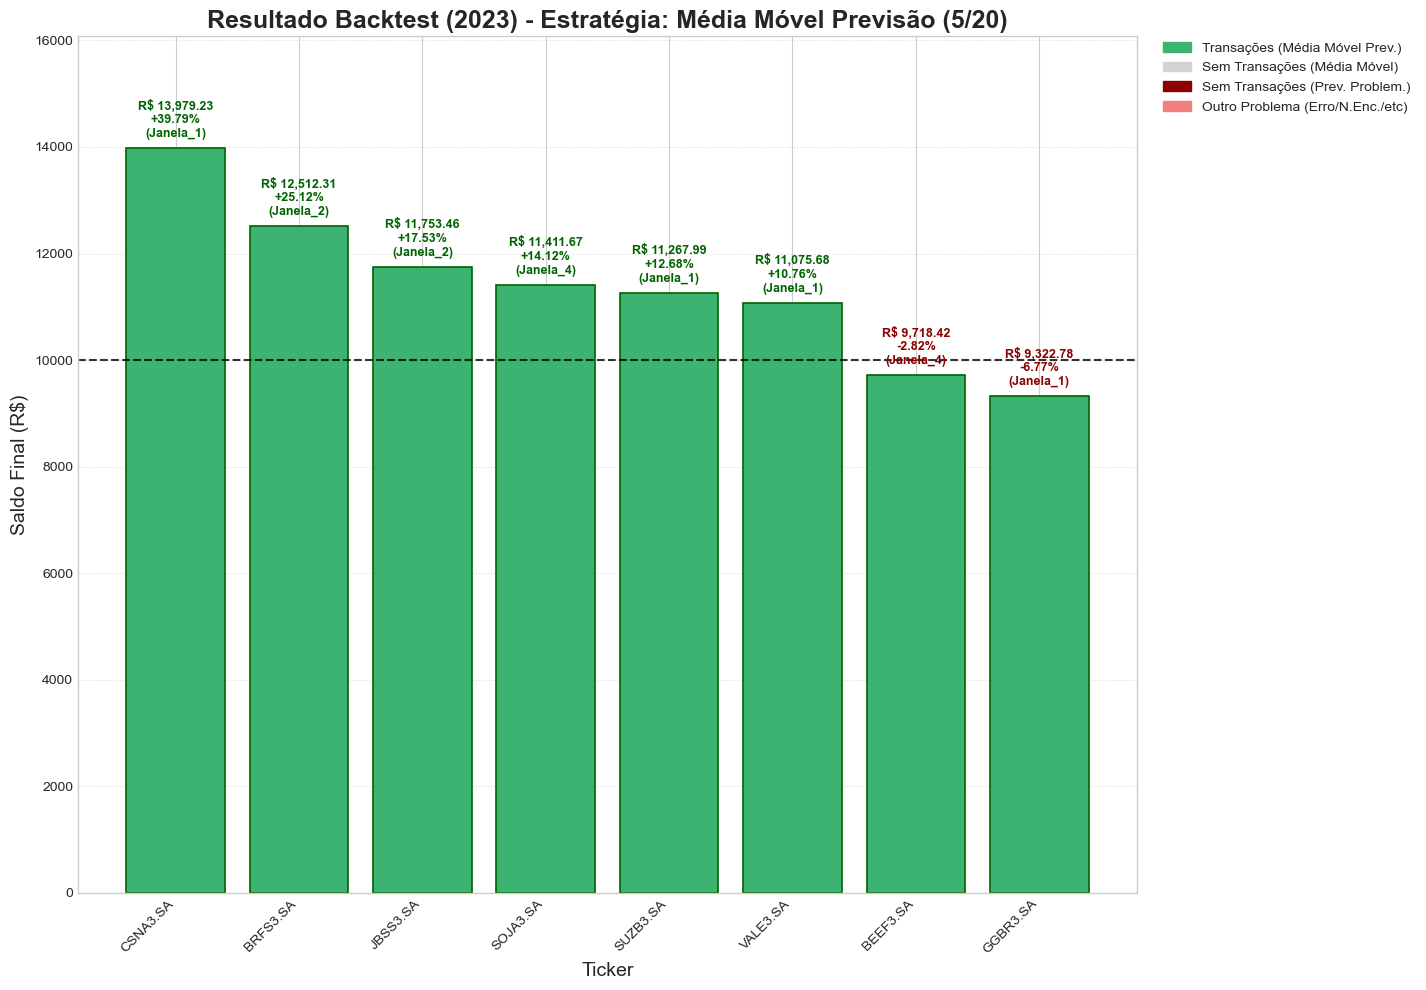


--- Execução Concluída (Estratégia Média Móvel Previsão) ---


In [54]:
# Cell 3: Estratégia Média Móvel Previsão (Nova Célula)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Importar mpatches

# Diretório onde estão os arquivos de previsões
input_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicro"

# Diretório onde os resultados serão salvos
output_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicroResultados"
os.makedirs(output_dir, exist_ok=True)

# Diretório para salvar as transações
transactions_dir = os.path.join(output_dir, "Transacoes_Estrategia_MediaMovel") # Subpasta para esta estratégia
os.makedirs(transactions_dir, exist_ok=True)

# Lista de tickers
tickers = ["BEEF3.SA", "BRFS3.SA", "VALE3.SA", "JBSS3.SA", "SOJA3.SA", "SUZB3.SA", "GGBR3.SA", "CSNA3.SA"]

# Lista de janelas
janelas = ["Janela_1", "Janela_2", "Janela_3", "Janela_4"]

# --- ESTRATÉGIA 3: Cruzamento de Médias Móveis da PREVISÃO ---
def estrategia_media_movel_previsao(dados_brutos, saldo_inicial, mm_curta=5, mm_longa=20):
    # Converter colunas para valores numéricos
    dados = dados_brutos.copy()
    dados['Preço Real'] = pd.to_numeric(dados['Preço Real'], errors='coerce')
    dados['Preço Previsto'] = pd.to_numeric(dados['Preço Previsto'], errors='coerce')

    # --- Verificação de Previsões Problemáticas (Mantida) ---
    previsoes = dados['Preço Previsto'].dropna()
    min_previsto = previsoes.min() if len(previsoes) > 0 else None
    max_previsto = previsoes.max() if len(previsoes) > 0 else None
    media_previsoes = previsoes.mean() if len(previsoes) > 0 else None
    identifier = dados_brutos['Data'].iloc[0] if not dados_brutos.empty and 'Data' in dados_brutos.columns else "Unknown"

    max_real_price = dados['Preço Real'].dropna().max()
    upper_limit = max(max_real_price * 10, 10000) if pd.notna(max_real_price) and max_real_price > 0 else 10000

    is_problematic = False
    reason = ""
    if any(p < 0 for p in previsoes if pd.notna(p)):
        is_problematic = True
        reason = f"Previsão negativa detectada (Min={min_previsto})"
    elif min_previsto is not None and isinstance(min_previsto, (int, float)) and min_previsto < -1000:
        is_problematic = True
        reason = f"Previsão mínima extrema detectada (Min={min_previsto})"
    elif max_previsto is not None and isinstance(max_previsto, (int, float)) and max_previsto > upper_limit:
        is_problematic = True
        reason = f"Previsão máxima extrema detectada (Max={max_previsto} > Limite={upper_limit})"

    if is_problematic:
        print(f"!!! DEBUG: Previsão problemática detectada para {identifier}. {reason}. Bloqueando transações (Média Móvel). !!!")
        diagnostico = {
            'Previsões Razoáveis': False,
            'Estratégia Usada': 'Sem transações - Previsões Problemáticas',
            'Total de Transações': 0, 'Retorno (%)': 0.0,
            'Min Previsto': min_previsto, 'Max Previsto': max_previsto, 'Média Previsto': media_previsoes
        }
        return saldo_inicial, [], diagnostico
    # --- Fim da Verificação ---

    # Calcular Médias Móveis da PREVISÃO
    dados['MM Curta Prev'] = dados['Preço Previsto'].rolling(window=mm_curta).mean()
    dados['MM Longa Prev'] = dados['Preço Previsto'].rolling(window=mm_longa).mean()

    saldo = saldo_inicial
    quantidade_acoes = 0
    transacoes = []
    sinal_compra = False
    sinal_venda = False

    # Começar a iterar após o período da MM longa para ter valores válidos
    for i in range(mm_longa, len(dados)):
        data_atual = dados.iloc[i]['Data']
        preco_real_atual = dados.iloc[i]['Preço Real']
        if pd.isna(preco_real_atual) or preco_real_atual <= 0: continue

        mm_curta_atual = dados.iloc[i]['MM Curta Prev']
        mm_longa_atual = dados.iloc[i]['MM Longa Prev']
        mm_curta_anterior = dados.iloc[i-1]['MM Curta Prev']
        mm_longa_anterior = dados.iloc[i-1]['MM Longa Prev']

        # Verificar se MMs são válidas
        if pd.isna(mm_curta_atual) or pd.isna(mm_longa_atual) or pd.isna(mm_curta_anterior) or pd.isna(mm_longa_anterior):
            continue

        # --- LÓGICA DE DECISÃO (Cruzamento de Médias Móveis da Previsão) ---
        # Sinal de Compra: MM Curta cruza ACIMA da MM Longa
        if mm_curta_anterior < mm_longa_anterior and mm_curta_atual > mm_longa_atual:
            sinal_compra = True
            sinal_venda = False
        # Sinal de Venda: MM Curta cruza ABAIXO da MM Longa
        elif mm_curta_anterior > mm_longa_anterior and mm_curta_atual < mm_longa_atual:
            sinal_compra = False
            sinal_venda = True
        else:
            # Mantém o estado anterior se não houver cruzamento
            pass
        # --- Fim da Lógica ---

        if quantidade_acoes == 0 and sinal_compra:
            quantidade_acoes = saldo / preco_real_atual # Compra ao preço real atual
            valor_transacao = saldo
            saldo = 0
            transacoes.append({'Data': data_atual, 'Acao': 'Compra', 'Preco': preco_real_atual, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
            sinal_compra = False # Resetar sinal após a ação
        elif quantidade_acoes > 0 and sinal_venda:
            valor_transacao = quantidade_acoes * preco_real_atual # Vende ao preço real atual
            saldo = valor_transacao
            transacoes.append({'Data': data_atual, 'Acao': 'Venda', 'Preco': preco_real_atual, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
            quantidade_acoes = 0
            sinal_venda = False # Resetar sinal após a ação

    # Venda final no último dia se ainda houver ações
    if quantidade_acoes > 0:
        ultimo_preco = dados.iloc[-1]['Preço Real']
        if not pd.isna(ultimo_preco) and ultimo_preco > 0:
            valor_transacao = quantidade_acoes * ultimo_preco
            saldo = valor_transacao
            transacoes.append({'Data': dados.iloc[-1]['Data'], 'Acao': 'Venda Final', 'Preco': ultimo_preco, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        else:
             print(f"AVISO: Último preço real inválido para {identifier}. Saldo zerado na venda final.")
             saldo = 0

    # Diagnóstico Final
    previsoes_razoaveis = not is_problematic
    estrategia_usada_diag = 'Media Movel Previsao' if len(transacoes) > 0 else 'Sem transações (Media Movel)'
    if is_problematic:
        estrategia_usada_diag = 'Sem transações - Previsões Problemáticas'

    diagnostico = {
        'Previsões Razoáveis': previsoes_razoaveis,
        'Estratégia Usada': estrategia_usada_diag,
        'Total de Transações': len(transacoes),
        'Retorno (%)': ((saldo - saldo_inicial) / saldo_inicial) * 100 if saldo_inicial != 0 else 0,
        'Min Previsto': min_previsto, 'Max Previsto': max_previsto, 'Média Previsto': media_previsoes
    }

    return saldo, transacoes, diagnostico

# Processar os resultados de previsões para todos os tickers, comparando as janelas (para Média Móvel)
def processar_previsoes_media_movel_comparativo(input_dir, tickers, janelas, saldo_inicial, mm_curta, mm_longa):
    resultados = []
    todas_transacoes = {}
    todos_diagnosticos = {}

    for ticker in tickers:
        ticker_resultados = {'Ticker': ticker}
        todas_transacoes[ticker] = {}
        todos_diagnosticos[ticker] = {}
        print(f"\nProcessando {ticker} (Estratégia Média Móvel Previsão)...") # Indicar estratégia
        for janela in janelas:
            previsoes_file = os.path.join(input_dir, ticker, janela, f"{ticker}_{janela}_previsoes_teste_final.csv")
            if os.path.exists(previsoes_file):
                try:
                    dados = pd.read_csv(previsoes_file)
                    # Limpar e adicionar identificador único para a função de estratégia
                    dados['Data'] = dados['Data'].astype(str).str.replace(r'_[A-Z0-9]+\.SA_Janela_[1-4]$', '', regex=True)
                    dados['Data_ID'] = dados['Data'] + f"_{ticker}_{janela}" # Usar coluna separada para ID

                    # --- CHAMANDO A ESTRATÉGIA DE MÉDIA MÓVEL ---
                    saldo_final, transacoes, diagnostico = estrategia_media_movel_previsao(
                        dados.rename(columns={'Data_ID': 'Data'}),
                        saldo_inicial,
                        mm_curta=mm_curta,
                        mm_longa=mm_longa
                    )
                    # --- Fim da Modificação ---
                    todas_transacoes[ticker][janela] = transacoes
                    todos_diagnosticos[ticker][janela] = diagnostico
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_final
                    ticker_resultados[f"Retorno {janela} (%)"] = diagnostico['Retorno (%)']
                    ticker_resultados[f"Estratégia {janela}"] = diagnostico['Estratégia Usada']
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = diagnostico['Previsões Razoáveis']
                    print(f"  {janela}: Saldo={saldo_final:.2f}, Estratégia='{diagnostico['Estratégia Usada']}'")
                except Exception as e:
                    print(f"  Erro ao processar {ticker} - {janela}: {str(e)}")
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                    ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                    ticker_resultados[f"Estratégia {janela}"] = "Erro"
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = False
            else:
                print(f"  Arquivo não encontrado: {previsoes_file}")
                ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                ticker_resultados[f"Estratégia {janela}"] = "Arquivo não encontrado"
                ticker_resultados[f"Previsões Razoáveis {janela}"] = False
        resultados.append(ticker_resultados)
    return pd.DataFrame(resultados), todas_transacoes, todos_diagnosticos

# --- CÓDIGO PRINCIPAL (Média Móvel) ---
saldo_inicial = 10000
mm_curta_param = 5  # Parâmetro da média móvel curta
mm_longa_param = 20 # Parâmetro da média móvel longa

df_resultados_mm, todas_transacoes_mm, todos_diagnosticos_mm = processar_previsoes_media_movel_comparativo(
    input_dir, tickers, janelas, saldo_inicial, mm_curta_param, mm_longa_param
)

# Salvar resultados comparativos
resultados_filepath_mm = os.path.join(output_dir, "resultados_comparativos_janelas_mediamovel.csv") # Nome do arquivo ajustado
df_resultados_mm.to_csv(resultados_filepath_mm, index=False)
print(f"\nResultados comparativos (Estratégia Média Móvel) salvos em: {resultados_filepath_mm}")

# Salvar diagnósticos
diagnosticos_list_mm = []
for ticker in todos_diagnosticos_mm:
    for janela in todos_diagnosticos_mm.get(ticker, {}):
        if todos_diagnosticos_mm[ticker][janela]:
            diagnostico = todos_diagnosticos_mm[ticker][janela].copy()
            diagnostico['Ticker'] = ticker; diagnostico['Janela'] = janela
            diagnosticos_list_mm.append(diagnostico)
if diagnosticos_list_mm:
    df_diagnosticos_mm = pd.DataFrame(diagnosticos_list_mm)
    diagnosticos_filepath_mm = os.path.join(output_dir, "diagnosticos_estrategia_mediamovel.csv") # Nome do arquivo ajustado
    df_diagnosticos_mm.to_csv(diagnosticos_filepath_mm, index=False)
    print(f"Diagnósticos de estratégias (Média Móvel) salvos em: {diagnosticos_filepath_mm}")

# Salvar TODAS as transações
print("\n--- Iniciando salvamento de TODAS as transações por janela (Estratégia Média Móvel) ---")
for ticker in tickers:
    ticker_dir = os.path.join(transactions_dir, ticker) # Usa a subpasta definida
    os.makedirs(ticker_dir, exist_ok=True)
    for janela in janelas:
        if janela in todas_transacoes_mm.get(ticker, {}):
            transacoes = todas_transacoes_mm[ticker][janela]
            if transacoes:
                df_transacoes = pd.DataFrame(transacoes)
                transacoes_filepath = os.path.join(ticker_dir, f"{ticker}_{janela}_transacoes_mediamovel.csv") # Nome do arquivo ajustado
                df_transacoes.to_csv(transacoes_filepath, index=False)
print("--- Salvamento de TODAS as transações (Média Móvel) concluído ---")


# Identificar a MELHOR JANELA para cada ticker (LÓGICA AJUSTADA para Estratégia Média Móvel)
print("\n--- Identificando melhor janela para cada ticker (Estratégia Média Móvel) ---")
melhores_resultados_plot_mm = []
for _, row in df_resultados_mm.iterrows():
    ticker = row['Ticker']

    melhor_janela_final = None
    melhor_saldo_final = -np.inf
    melhor_estrategia_final = None
    tem_transacoes_final = False
    print_msg = "Nenhuma janela válida encontrada"

    # 1. Buscar a melhor janela COM transações ('Media Movel Previsao')
    melhor_janela_com_trans = None
    melhor_saldo_com_trans = -np.inf
    for janela in janelas:
        estrategia = row.get(f"Estratégia {janela}")
        saldo = row.get(f"Saldo Final {janela}")
        if estrategia == 'Media Movel Previsao' and saldo is not None and pd.notna(saldo):
            if saldo > melhor_saldo_com_trans:
                melhor_saldo_com_trans = saldo
                melhor_janela_com_trans = janela

    # 2. Se encontrou janela COM transações, usar essa
    if melhor_janela_com_trans is not None:
        melhor_janela_final = melhor_janela_com_trans
        melhor_saldo_final = melhor_saldo_com_trans
        melhor_estrategia_final = 'Media Movel Previsao'
        tem_transacoes_final = True
        print_msg = "Melhor janela válida com transações (Média Móvel)"
    else:
        # 3. Se NÃO encontrou com transações, buscar a melhor janela SEM transações NORMAL ('Sem transações (Media Movel)')
        melhor_janela_sem_trans_normal = None
        for janela in janelas:
            estrategia = row.get(f"Estratégia {janela}")
            if estrategia == 'Sem transações (Media Movel)':
                 if melhor_janela_sem_trans_normal is None:
                     melhor_janela_sem_trans_normal = janela
                     break

        # 4. Se encontrou janela 'Sem transações (Media Movel)', usar essa
        if melhor_janela_sem_trans_normal is not None:
             melhor_janela_final = melhor_janela_sem_trans_normal
             melhor_saldo_final = saldo_inicial
             melhor_estrategia_final = 'Sem transações (Media Movel)'
             tem_transacoes_final = False
             print_msg = "Janela selecionada (sem transações - Média Móvel)"
        else:
             # 5. Se não achou nem com transação, nem sem transação normal, procurar por 'Sem transações - Previsões Problemáticas'
             melhor_janela_problematica = None
             for janela in janelas:
                 estrategia = row.get(f"Estratégia {janela}")
                 if estrategia == 'Sem transações - Previsões Problemáticas':
                     if melhor_janela_problematica is None:
                         melhor_janela_problematica = janela
                         break

             if melhor_janela_problematica is not None:
                 melhor_janela_final = melhor_janela_problematica
                 melhor_saldo_final = saldo_inicial
                 melhor_estrategia_final = 'Sem transações - Previsões Problemáticas'
                 tem_transacoes_final = False
                 print_msg = "Janela selecionada (previsões problemáticas)"
             else:
                 # 6. Fallback extremo: Se sobrou apenas 'Erro' ou 'Arquivo não encontrado'
                 melhor_janela_final = janelas[0]
                 melhor_saldo_final = saldo_inicial
                 melhor_estrategia_final = row.get(f"Estratégia {janelas[0]}", "Status Desconhecido")
                 tem_transacoes_final = False
                 print_msg = "Janela selecionada (fallback extremo - Média Móvel)"
                 if melhor_estrategia_final not in ['Sem transações (Media Movel)', 'Sem transações - Previsões Problemáticas', 'Erro', 'Arquivo não encontrado']:
                     melhor_estrategia_final = 'Status Desconhecido'

    # Adicionar aos resultados para plotagem
    previsoes_razoaveis = melhor_estrategia_final not in ['Sem transações - Previsões Problemáticas', 'Erro', 'Arquivo não encontrado', 'Status Desconhecido']

    if not tem_transacoes_final:
        melhor_saldo_final = saldo_inicial

    melhores_resultados_plot_mm.append({
        'Ticker': ticker,
        'Melhor Janela': melhor_janela_final,
        'Saldo Final': melhor_saldo_final,
        'Retorno (%)': ((melhor_saldo_final - saldo_inicial) / saldo_inicial) * 100 if saldo_inicial != 0 else 0,
        'Estratégia Usada': melhor_estrategia_final if melhor_estrategia_final is not None else "N/A",
        'Previsões Razoáveis': previsoes_razoaveis,
        'Tem Transações': tem_transacoes_final
    })
    print(f"    {print_msg} para {ticker}: {melhor_janela_final} (Saldo: {melhor_saldo_final:.2f}, Estratégia: {melhor_estrategia_final})")

# Processar e salvar MELHORES resultados
df_melhores_plot_mm = pd.DataFrame(melhores_resultados_plot_mm).sort_values(by='Retorno (%)', ascending=False)

melhores_filepath_mm = os.path.join(output_dir, "melhores_resultados_mediamovel.csv") # Nome do arquivo ajustado
df_melhores_plot_mm.to_csv(melhores_filepath_mm, index=False)
print(f"\nMelhores resultados (Estratégia Média Móvel) salvos em: {melhores_filepath_mm}")

# Salvar transações SOMENTE da MELHOR JANELA (se teve transações)
print("\n--- Iniciando salvamento das transações da MELHOR janela (Estratégia Média Móvel) ---")
todas_melhores_transacoes_list_mm = []
for idx, row in df_melhores_plot_mm.iterrows():
    ticker = row['Ticker']
    melhor_janela = row['Melhor Janela']

    if not row['Tem Transações']:
        continue

    if ticker in todas_transacoes_mm and melhor_janela in todas_transacoes_mm.get(ticker, {}):
        transacoes_melhor = todas_transacoes_mm[ticker][melhor_janela]
        if transacoes_melhor:
            df_transacoes_melhor = pd.DataFrame(transacoes_melhor)
            melhor_transacoes_filepath = os.path.join(transactions_dir, f"{ticker}_MELHOR_JANELA_{melhor_janela}_transacoes_mediamovel.csv") # Nome ajustado
            df_transacoes_melhor.to_csv(melhor_transacoes_filepath, index=False)

            for transacao in transacoes_melhor:
                transacao_info = {'Ticker': ticker, 'Janela': melhor_janela, 'Estratégia': row['Estratégia Usada'], 'Previsões Razoáveis': row['Previsões Razoáveis'], **transacao}
                todas_melhores_transacoes_list_mm.append(transacao_info)
print("--- Salvamento das MELHORES transações (Média Móvel) concluído ---")

# Salvar consolidado se houver dados
if todas_melhores_transacoes_list_mm:
    df_todas_melhores_mm = pd.DataFrame(todas_melhores_transacoes_list_mm)
    consolidado_filepath_mm = os.path.join(output_dir, "todas_melhores_transacoes_consolidado_mediamovel.csv") # Nome ajustado
    df_todas_melhores_mm.to_csv(consolidado_filepath_mm, index=False)
    print(f"\nTodas as transações das melhores janelas (Média Móvel) consolidadas em: {consolidado_filepath_mm}")

# Gerar gráfico final (incluindo todos os tickers)
print("\n--- Gerando gráfico final (Estratégia Média Móvel Previsão) ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 10))

# Cores baseadas na lógica ajustada para Estratégia Média Móvel
colors = []
edge_colors = []
for idx, row in df_melhores_plot_mm.iterrows():
    if row['Estratégia Usada'] == 'Sem transações - Previsões Problemáticas':
         colors.append('darkred')
         edge_colors.append('black')
    elif not row['Tem Transações']: # Estratégia foi 'Sem transações (Media Movel)'
        colors.append('lightgray')
        edge_colors.append('dimgray')
    elif row['Previsões Razoáveis']: # Estratégia foi 'Media Movel Previsao' e razoável
        colors.append('mediumseagreen')
        edge_colors.append('darkgreen')
    else: # Outros casos (Erro, Arquivo não encontrado, Status Desconhecido)
        colors.append('lightcoral')
        edge_colors.append('darkred')


bars = plt.bar(df_melhores_plot_mm['Ticker'], df_melhores_plot_mm['Saldo Final'],
               color=colors, edgecolor=edge_colors, linewidth=1.2)
plt.axhline(y=saldo_inicial, color='black', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')

# Adicionar rótulos com informações
for i, bar in enumerate(bars):
    row = df_melhores_plot_mm.iloc[i]
    saldo = row['Saldo Final']
    retorno = row['Retorno (%)']
    janela = row['Melhor Janela']
    estrategia = row['Estratégia Usada']

    y_pos = bar.get_height() + 150

    if estrategia == 'Sem transações - Previsões Problemáticas':
         plt.text(i, y_pos, "Previsões\nProblemáticas", ha='center', va='bottom', color='darkred', fontsize=9, fontweight='bold')
    elif not row['Tem Transações']: # Estratégia 'Sem transações (Media Movel)'
        plt.text(i, y_pos, f"Sem Trans.\n(M.Móvel)\n({janela})", ha='center', va='bottom', color='dimgray', fontsize=9) # Texto ajustado
    elif estrategia == 'Media Movel Previsao':
        text_color = 'darkgreen' if retorno >= 0 else 'darkred'
        retorno_text = f"+{retorno:.2f}%" if retorno >= 0 else f"{retorno:.2f}%"
        plt.text(i, y_pos,
                 f"R$ {saldo:,.2f}\n{retorno_text}\n({janela})",
                 ha='center', va='bottom', fontweight='bold', color=text_color, fontsize=9)
    else: # Outros casos
        plt.text(i, y_pos, f"{estrategia}\n({janela})", ha='center', va='bottom', color='darkred', fontsize=9)


# --- TÍTULO DO GRÁFICO AJUSTADO ---
plt.title(f'Resultado Backtest (2023) - Estratégia: Média Móvel Previsão ({mm_curta_param}/{mm_longa_param})', fontsize=18, fontweight='bold')
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Saldo Final (R$)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.ylim(bottom=0, top=max(df_melhores_plot_mm['Saldo Final'].max() * 1.15, saldo_inicial * 1.2))


# Legenda Atualizada para Estratégia Média Móvel
trans_razoaveis_patch = mpatches.Patch(color='mediumseagreen', label='Transações (Média Móvel Prev.)') # Label ajustado
sem_trans_patch = mpatches.Patch(color='lightgray', label='Sem Transações (Média Móvel)') # Label ajustado
prev_prob_patch = mpatches.Patch(color='darkred', label='Sem Transações (Prev. Problem.)')
outros_prob_patch = mpatches.Patch(color='lightcoral', label='Outro Problema (Erro/N.Enc./etc)')

plt.legend(handles=[trans_razoaveis_patch, sem_trans_patch, prev_prob_patch, outros_prob_patch, bars[0]],
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10)
plt.tight_layout(rect=[0, 0, 0.9, 1])

grafico_final_filepath_mm = os.path.join(output_dir, "resultado_trading_grafico_mediamovel.png") # Nome do arquivo ajustado
plt.savefig(grafico_final_filepath_mm, dpi=300, bbox_inches='tight')
print(f"Gráfico final (Estratégia Média Móvel) salvo em: {grafico_final_filepath_mm}")
plt.show()

print("\n--- Execução Concluída (Estratégia Média Móvel Previsão) ---")


Processando PETR4.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=21037.89, Retorno=110.38%

Processando BEEF3.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=6237.15, Retorno=-37.63%

Processando BRFS3.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=17349.25, Retorno=73.49%

Processando VALE3.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=9181.48, Retorno=-8.19%

Processando JBSS3.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=12266.21, Retorno=22.66%

Processando SOJA3.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=16966.38, Retorno=69.66%

Processando SUZB3.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=11623.31, Retorno=16.23%

Processando GGBR3.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=9036.22, Retorno=-9.64%

Processando CSNA3.SA (Estratégia Buy and Hold)...
  Resultado Buy and Hold: Saldo=14596.89, Retorno=45.97%

Resultados comparativos (Est

C:\Users\leona\AppData\Local\Temp\ipykernel_14324\3558920288.py:288: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=[bh_positivo_patch, bh_negativo_patch, bh_erro_patch, bars[0]], # Adiciona linha do saldo inicial


Gráfico final (Estratégia Buy and Hold) salvo em: c:\Users\leona\pyhtonscripts\ExperimentosTeste\KfoldResultados\resultado_trading_grafico_buyhold.png


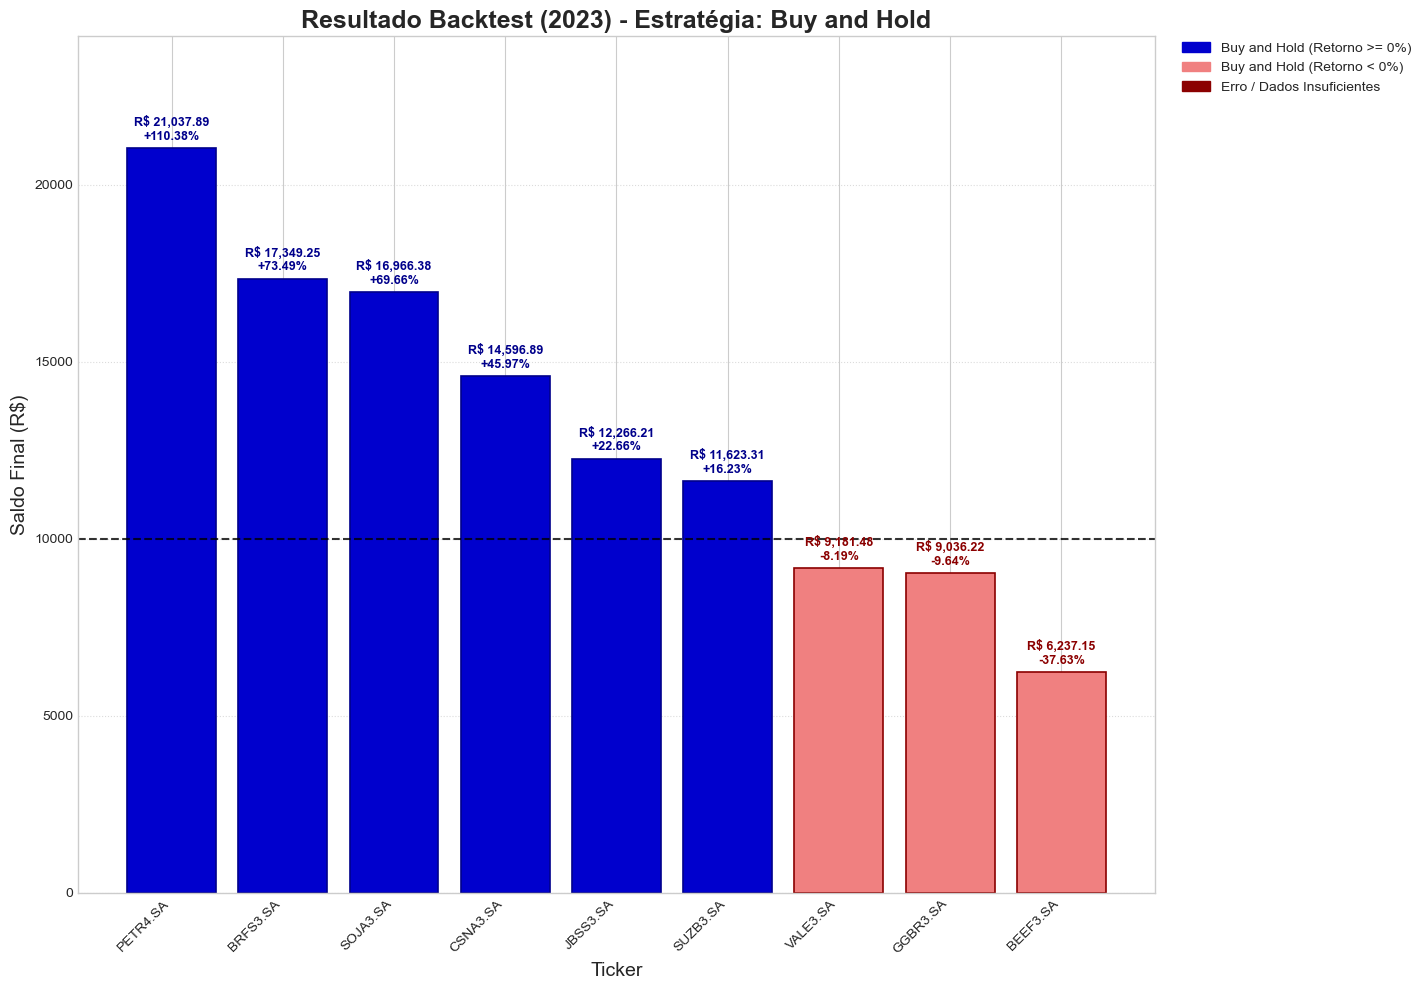


--- Execução Concluída (Estratégia Buy and Hold) ---


In [53]:
# Cell 4: Estratégia Buy and Hold (Nova Célula)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Importar mpatches

# Diretório onde estão os arquivos de previsões (usado para pegar os preços reais)
input_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicro"

# Diretório onde os resultados serão salvos
output_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\KfoldResultados"
os.makedirs(output_dir, exist_ok=True)

# Diretório para salvar as transações (apenas 2 por ticker)
transactions_dir = os.path.join(output_dir, "Transacoes_Estrategia_BuyHold") # Subpasta para esta estratégia
os.makedirs(transactions_dir, exist_ok=True)

# Lista de tickers
tickers = ["PETR4.SA", "BEEF3.SA", "BRFS3.SA", "VALE3.SA", "JBSS3.SA", "SOJA3.SA", "SUZB3.SA", "GGBR3.SA", "CSNA3.SA"]

# Lista de janelas (usada apenas para encontrar um arquivo de dados por ticker)
janelas = ["Janela_1", "Janela_2", "Janela_3", "Janela_4"]

# --- ESTRATÉGIA 4: Buy and Hold ---
def estrategia_buy_and_hold(dados_brutos, saldo_inicial):
    # Converter coluna de Preço Real
    dados = dados_brutos.copy()
    dados['Preço Real'] = pd.to_numeric(dados['Preço Real'], errors='coerce')
    dados = dados.dropna(subset=['Preço Real']) # Remove dias sem preço real
    dados = dados[dados['Preço Real'] > 0] # Remove dias com preço real zero ou negativo

    identifier = dados_brutos['Data'].iloc[0] if not dados_brutos.empty and 'Data' in dados_brutos.columns else "Unknown" # Para mensagens de erro

    saldo = saldo_inicial
    quantidade_acoes = 0
    transacoes = []

    if len(dados) < 2: # Precisa de pelo menos 2 pontos para comprar e vender
        print(f"AVISO: Dados insuficientes para Buy and Hold em {identifier}. Retornando saldo inicial.")
        diagnostico = {
            'Estratégia Usada': 'Buy and Hold (Dados Insuficientes)',
            'Total de Transações': 0,
            'Retorno (%)': 0.0,
        }
        return saldo_inicial, [], diagnostico

    # Compra no primeiro dia com preço válido
    preco_compra = dados.iloc[0]['Preço Real']
    data_compra = dados.iloc[0]['Data']
    quantidade_acoes = saldo / preco_compra
    valor_transacao_compra = saldo
    saldo = 0
    transacoes.append({'Data': data_compra, 'Acao': 'Compra Inicial', 'Preco': preco_compra, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao_compra, 'Saldo Restante': saldo})

    # Venda no último dia com preço válido
    preco_venda = dados.iloc[-1]['Preço Real']
    data_venda = dados.iloc[-1]['Data']
    valor_transacao_venda = quantidade_acoes * preco_venda
    saldo = valor_transacao_venda
    transacoes.append({'Data': data_venda, 'Acao': 'Venda Final', 'Preco': preco_venda, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao_venda, 'Saldo Restante': saldo})
    quantidade_acoes = 0

    # Diagnóstico Final
    diagnostico = {
        'Estratégia Usada': 'Buy and Hold',
        'Total de Transações': len(transacoes),
        'Retorno (%)': ((saldo - saldo_inicial) / saldo_inicial) * 100 if saldo_inicial != 0 else 0,
    }

    return saldo, transacoes, diagnostico

# Processar os resultados para Buy and Hold (só precisa de um arquivo por ticker)
def processar_buy_and_hold_comparativo(input_dir, tickers, janelas, saldo_inicial):
    resultados = []
    todas_transacoes = {}
    todos_diagnosticos = {}

    for ticker in tickers:
        ticker_resultados = {'Ticker': ticker}
        todas_transacoes[ticker] = {} # Armazenará transações (mesmo que só 2)
        todos_diagnosticos[ticker] = {} # Armazenará diagnóstico
        print(f"\nProcessando {ticker} (Estratégia Buy and Hold)...")

        dados_carregados = False
        # Tenta carregar dados de qualquer janela (precisamos apenas dos preços reais)
        for janela in janelas:
            previsoes_file = os.path.join(input_dir, ticker, janela, f"{ticker}_{janela}_previsoes_teste_final.csv")
            if os.path.exists(previsoes_file):
                try:
                    dados = pd.read_csv(previsoes_file)
                    # Limpa o ID da Data se existir, para Buy and Hold não faz diferença
                    dados['Data'] = dados['Data'].astype(str).str.replace(r'_[A-Z0-9]+\.SA_Janela_[1-4]$', '', regex=True)

                    # --- CHAMANDO A ESTRATÉGIA BUY AND HOLD ---
                    # Passa um identificador único para a função, caso precise debugar
                    dados['Data_ID'] = dados['Data'] + f"_{ticker}_BuyHold"
                    saldo_final, transacoes, diagnostico = estrategia_buy_and_hold(
                        dados.rename(columns={'Data_ID': 'Data'}),
                        saldo_inicial
                    )
                    # --- Fim da Modificação ---

                    # Armazena o resultado (será o mesmo para todas as janelas)
                    # Usamos a 'Janela_1' como chave padrão, mas o resultado é independente da janela
                    chave_janela = "Janela_1" # Apenas para ter uma chave
                    todas_transacoes[ticker][chave_janela] = transacoes
                    todos_diagnosticos[ticker][chave_janela] = diagnostico
                    ticker_resultados[f"Saldo Final {chave_janela}"] = saldo_final
                    ticker_resultados[f"Retorno {chave_janela} (%)"] = diagnostico['Retorno (%)']
                    ticker_resultados[f"Estratégia {chave_janela}"] = diagnostico['Estratégia Usada']
                    print(f"  Resultado Buy and Hold: Saldo={saldo_final:.2f}, Retorno={diagnostico['Retorno (%)']:.2f}%")
                    dados_carregados = True
                    break # Sai do loop de janelas, já temos o resultado do Buy and Hold

                except Exception as e:
                    print(f"  Erro ao processar {ticker} - {janela} para Buy and Hold: {str(e)}")
                    # Preenche com erro se falhar
                    chave_janela = "Janela_1"
                    ticker_resultados[f"Saldo Final {chave_janela}"] = saldo_inicial
                    ticker_resultados[f"Retorno {chave_janela} (%)"] = 0.0
                    ticker_resultados[f"Estratégia {chave_janela}"] = "Erro"
                    todos_diagnosticos[ticker][chave_janela] = {'Estratégia Usada': 'Erro', 'Total de Transações': 0, 'Retorno (%)': 0.0}
                    dados_carregados = True # Marca como carregado para não tentar outras janelas
                    break # Sai do loop de janelas

        if not dados_carregados:
             print(f"  Nenhum arquivo encontrado para {ticker}.")
             chave_janela = "Janela_1"
             ticker_resultados[f"Saldo Final {chave_janela}"] = saldo_inicial
             ticker_resultados[f"Retorno {chave_janela} (%)"] = 0.0
             ticker_resultados[f"Estratégia {chave_janela}"] = "Arquivo não encontrado"
             todos_diagnosticos[ticker][chave_janela] = {'Estratégia Usada': 'Arquivo não encontrado', 'Total de Transações': 0, 'Retorno (%)': 0.0}

        resultados.append(ticker_resultados)
    return pd.DataFrame(resultados), todas_transacoes, todos_diagnosticos

# --- CÓDIGO PRINCIPAL (Buy and Hold) ---
saldo_inicial = 10000

df_resultados_bh, todas_transacoes_bh, todos_diagnosticos_bh = processar_buy_and_hold_comparativo(
    input_dir, tickers, janelas, saldo_inicial
)

# Salvar resultados comparativos (terá apenas uma coluna de resultado por ticker)
resultados_filepath_bh = os.path.join(output_dir, "resultados_comparativos_buyhold.csv")
df_resultados_bh.to_csv(resultados_filepath_bh, index=False)
print(f"\nResultados comparativos (Estratégia Buy and Hold) salvos em: {resultados_filepath_bh}")

# Salvar diagnósticos (simplificado para Buy and Hold)
diagnosticos_list_bh = []
for ticker in todos_diagnosticos_bh:
    # Pega o diagnóstico da 'Janela_1' (ou a chave que foi usada)
    chave_janela = list(todos_diagnosticos_bh[ticker].keys())[0] if todos_diagnosticos_bh[ticker] else None
    if chave_janela and todos_diagnosticos_bh[ticker][chave_janela]:
        diagnostico = todos_diagnosticos_bh[ticker][chave_janela].copy()
        diagnostico['Ticker'] = ticker
        diagnostico['Janela'] = 'N/A (Buy and Hold)' # Janela não é relevante
        diagnosticos_list_bh.append(diagnostico)
if diagnosticos_list_bh:
    df_diagnosticos_bh = pd.DataFrame(diagnosticos_list_bh)
    diagnosticos_filepath_bh = os.path.join(output_dir, "diagnosticos_estrategia_buyhold.csv")
    df_diagnosticos_bh.to_csv(diagnosticos_filepath_bh, index=False)
    print(f"Diagnósticos de estratégias (Buy and Hold) salvos em: {diagnosticos_filepath_bh}")

# Salvar TODAS as transações (apenas Compra Inicial e Venda Final)
print("\n--- Iniciando salvamento das transações (Estratégia Buy and Hold) ---")
todas_bh_transacoes_list = []
for ticker in tickers:
    ticker_dir = os.path.join(transactions_dir, ticker)
    os.makedirs(ticker_dir, exist_ok=True)
    chave_janela = list(todas_transacoes_bh.get(ticker, {}).keys())[0] if todas_transacoes_bh.get(ticker) else None
    if chave_janela and todas_transacoes_bh[ticker][chave_janela]:
        transacoes = todas_transacoes_bh[ticker][chave_janela]
        if transacoes:
            df_transacoes = pd.DataFrame(transacoes)
            transacoes_filepath = os.path.join(ticker_dir, f"{ticker}_transacoes_buyhold.csv")
            df_transacoes.to_csv(transacoes_filepath, index=False)
            # Adicionar ao consolidado
            for transacao in transacoes:
                 transacao_info = {'Ticker': ticker, 'Janela': 'N/A', 'Estratégia': 'Buy and Hold', **transacao}
                 todas_bh_transacoes_list.append(transacao_info)

print("--- Salvamento das transações (Buy and Hold) concluído ---")

# Salvar consolidado se houver dados
if todas_bh_transacoes_list:
    df_todas_bh_transacoes = pd.DataFrame(todas_bh_transacoes_list)
    consolidado_filepath_bh = os.path.join(output_dir, "todas_transacoes_consolidado_buyhold.csv")
    df_todas_bh_transacoes.to_csv(consolidado_filepath_bh, index=False)
    print(f"\nTodas as transações (Buy and Hold) consolidadas em: {consolidado_filepath_bh}")


# Preparar dados para o gráfico Buy and Hold
print("\n--- Preparando dados para gráfico Buy and Hold ---")
melhores_resultados_plot_bh = []
# A lógica de "melhor janela" não se aplica, pegamos o resultado direto
for _, row in df_resultados_bh.iterrows():
    ticker = row['Ticker']
    # Pega os resultados da chave 'Janela_1' (ou a que foi usada)
    chave_janela = "Janela_1"
    saldo_final = row.get(f"Saldo Final {chave_janela}", saldo_inicial)
    retorno = row.get(f"Retorno {chave_janela} (%)", 0.0)
    estrategia = row.get(f"Estratégia {chave_janela}", "Status Desconhecido")

    # Garante que o saldo seja inicial se a estratégia falhou
    if estrategia not in ['Buy and Hold', 'Buy and Hold (Dados Insuficientes)']:
        saldo_final = saldo_inicial
        retorno = 0.0

    melhores_resultados_plot_bh.append({
        'Ticker': ticker,
        'Melhor Janela': 'N/A', # Não aplicável
        'Saldo Final': saldo_final,
        'Retorno (%)': retorno,
        'Estratégia Usada': estrategia,
        'Previsões Razoáveis': True, # Não depende de previsões
        'Tem Transações': estrategia == 'Buy and Hold' # Teve transações se não deu erro/dados insuficientes
    })
    print(f"    {ticker}: Saldo Final={saldo_final:.2f}, Estratégia='{estrategia}'")

# Processar e salvar MELHORES resultados (que são os únicos resultados para B&H)
df_melhores_plot_bh = pd.DataFrame(melhores_resultados_plot_bh).sort_values(by='Retorno (%)', ascending=False)

melhores_filepath_bh = os.path.join(output_dir, "melhores_resultados_buyhold.csv")
df_melhores_plot_bh.to_csv(melhores_filepath_bh, index=False)
print(f"\nResultados finais (Buy and Hold) salvos em: {melhores_filepath_bh}")


# Gerar gráfico final (Buy and Hold)
print("\n--- Gerando gráfico final (Estratégia Buy and Hold) ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 10))

# Cores para Buy and Hold (Positivo/Negativo/Erro)
colors = []
edge_colors = []
for idx, row in df_melhores_plot_bh.iterrows():
    if row['Estratégia Usada'] not in ['Buy and Hold', 'Buy and Hold (Dados Insuficientes)']: # Erro ou Arquivo não encontrado
         colors.append('darkred')
         edge_colors.append('black')
    elif row['Retorno (%)'] >= 0:
        colors.append('mediumblue') # Azul para retorno positivo
        edge_colors.append('darkblue')
    else: # Retorno negativo
        colors.append('lightcoral') # Coral para retorno negativo
        edge_colors.append('darkred')


bars = plt.bar(df_melhores_plot_bh['Ticker'], df_melhores_plot_bh['Saldo Final'],
               color=colors, edgecolor=edge_colors, linewidth=1.2)
plt.axhline(y=saldo_inicial, color='black', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')

# Adicionar rótulos com informações
for i, bar in enumerate(bars):
    row = df_melhores_plot_bh.iloc[i]
    saldo = row['Saldo Final']
    retorno = row['Retorno (%)']
    estrategia = row['Estratégia Usada']

    y_pos = bar.get_height() + 150

    if estrategia not in ['Buy and Hold', 'Buy and Hold (Dados Insuficientes)']:
         plt.text(i, y_pos, f"{estrategia}", ha='center', va='bottom', color='darkred', fontsize=9, fontweight='bold')
    else:
        text_color = 'darkblue' if retorno >= 0 else 'darkred'
        retorno_text = f"+{retorno:.2f}%" if retorno >= 0 else f"{retorno:.2f}%"
        plt.text(i, y_pos,
                 f"R$ {saldo:,.2f}\n{retorno_text}",
                 ha='center', va='bottom', fontweight='bold', color=text_color, fontsize=9)


# --- TÍTULO DO GRÁFICO AJUSTADO ---
plt.title('Resultado Backtest (2023) - Estratégia: Buy and Hold', fontsize=18, fontweight='bold')
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Saldo Final (R$)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.ylim(bottom=0, top=max(df_melhores_plot_bh['Saldo Final'].max() * 1.15, saldo_inicial * 1.2))


# Legenda Atualizada para Buy and Hold
bh_positivo_patch = mpatches.Patch(color='mediumblue', label='Buy and Hold (Retorno >= 0%)')
bh_negativo_patch = mpatches.Patch(color='lightcoral', label='Buy and Hold (Retorno < 0%)')
bh_erro_patch = mpatches.Patch(color='darkred', label='Erro / Dados Insuficientes')

plt.legend(handles=[bh_positivo_patch, bh_negativo_patch, bh_erro_patch, bars[0]], # Adiciona linha do saldo inicial
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10)
plt.tight_layout(rect=[0, 0, 0.9, 1])

grafico_final_filepath_bh = os.path.join(output_dir, "resultado_trading_grafico_buyhold.png")
plt.savefig(grafico_final_filepath_bh, dpi=300, bbox_inches='tight')
print(f"Gráfico final (Estratégia Buy and Hold) salvo em: {grafico_final_filepath_bh}")
plt.show()

print("\n--- Execução Concluída (Estratégia Buy and Hold) ---")
